In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import os
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
import plotly.graph_objects as go
import plotly.offline as pyo
import datetime
import matplotlib.dates as mdates

# YKD LAKE Model Benchmarking
This script is used to compare one or multiple LAKE model runs with obsereved water temperatures and concentrations of CO2 and CH4. The data preparation relies on LAKE model output in the second format option (output files ending in '1f2.dat').

In [2]:
def parse_methane_series(filepath):
    '''
    Read in LAKE model methane file 'methane_series 1 1.dat'

    Args:
    filepath (string): full filepath to methane file

    Output:
    methane (pd.DataFrame)
    '''
    methane=pd.read_csv(filepath, delimiter=r"\s+", skiprows=35, index_col=None, header=None)
    methane.columns=['year', 'month', 'day', 'hour', 'integration_time',  'talik depth, m',
                    'lake surface methane concentration, mol/m**3',
                    'lake bottom methane concentration, mol/m**3',
                    'soil bottom methane concentration, mol/m**3',
                    'lake surface oxygen concentration, mol/m**3',
                    'lake bottom oxygen concentration, mol/m**3',
                    'total methane production due to young C decomposition, mol/(m**2*s)',
                    'total methane production due to old C decomposition, mol/(m**2*s)',
                    'methane ebullition flux averaged over the lake bottom, upwards, mol/(m**2*s)',
                    'methane ebullition flux at the surface, mol/(m**2*s)',
                    'methane plant-mediated flux at the lake bottom, mol/(m**2*s)',
                    'methane diffusion flux averaged over the lake bottom, upwards, mol/(m**2*s)',
                    'methane turbulent flux at the lake surface, upwards, mol/(m**2*s)',
                    'methane ebullition flux averaged over the lake bottom, upwards, mg/(m**2*day)',
                    'methane ebullition flux at the surface, mg/(m**2*day)',
                    'methane plant-mediated flux at the lake bottom, mg/(m**2*day)',
                    'methane diffusion flux averaged over lake bottom, upwards, mg/(m**2*day)',
                    'methane turbulent flux at the lake surface, upwards, mg/(m**2*day)',
                    'methane turbulent flux at the bottom of mixed layer normalized by  surface area, upwards, mg/(m**2*day)',
                    'methane flux from sediments in the mixed layer normalized by  surface area, upwards, mg/(m**2*day)',
                    'methane bubble flux at the bottom of the mixed layer normalized by  surface area, upwards, mg/(m**2*day)',
                    'total methane oxidation in water normalized by  surface area, mg/(m**2*day)',
                    'methane oxidation in mixed layer normalized by  surface area, mg/(m**2*day)',
                    'co2 turbulent flux at the lake surface, upwards, mol/(m**2*s)',
                    'co2 ebullition flux at the surface, mol/(m**2*s)',
                    'oxygen turbulent flux at the lake surface, upwards, mol/(m**2*s)',
                    'oxygen ebullition flux at the surface, mol/(m**2*s)',
                    'methane flux by inlets, normalized by surface area, mol/(m**2*s)',
                    'methane flux through outlet, normalized by surface area, mol/(m**2*s)',
                    'methane_ebul_sc1', 'methane_ebul_sc2', 'methane_ebul_sc3', 'methane_ebul_sc4', 'methane_ebul_sc5'] #mg/(m**2*day)
    
    methane['Date'] = pd.to_datetime({'Year': methane['year'], 'Month': methane['month'], 'Day':methane['day']})
    methane = methane[['Date','year', 'month', 'day', 'hour', 'total methane production due to young C decomposition, mol/(m**2*s)',
                       'total methane production due to old C decomposition, mol/(m**2*s)', 'methane diffusion flux averaged over the lake bottom, upwards, mol/(m**2*s)',
                       'methane ebullition flux at the surface, mol/(m**2*s)',
                       'methane ebullition flux at the surface, mg/(m**2*day)',
                       'methane turbulent flux at the lake surface, upwards, mol/(m**2*s)',
                       'methane turbulent flux at the lake surface, upwards, mg/(m**2*day)',
                       'total methane oxidation in water normalized by  surface area, mg/(m**2*day)',
                       'methane plant-mediated flux at the lake bottom, mg/(m**2*day)',
                       'co2 turbulent flux at the lake surface, upwards, mol/(m**2*s)',
                       'co2 ebullition flux at the surface, mol/(m**2*s)',
                       'oxygen turbulent flux at the lake surface, upwards, mol/(m**2*s)',
                       'oxygen ebullition flux at the surface, mol/(m**2*s)',
                       'methane_ebul_sc1', 'methane_ebul_sc2', 'methane_ebul_sc3', 'methane_ebul_sc4', 'methane_ebul_sc5']]
    
    methane.columns = ['Date', 'year', 'month', 'day', 'hour', 'methane_prod_young_mol/(m**2*s)', 'methane_prod_old_mol/(m**2*s)', 'methane_diffuse_bot_mol/(m**2*s)',
                       'methane_ebul_mol/(m**2*s)', 'methane_ebul_mg/(m**2*day)', 'methane_turb_flux_mol/(m**2*s)', 'methane_turb_flux_mg/(m**2*day)',
                      'methane_oxid_mg/(m**2*day)', 'methane_plant_med_flux_mg/(m**2*day)','co2_turb_flux_mol/(m**2*s)', 'co2_ebul_mol/(m**2*s)', 'ox_turb_flux_mol/(m**2*s)', 'ox_ebul_mol/(m**2*s)',
                      'methane_ebul_sc1', 'methane_ebul_sc2', 'methane_ebul_sc3', 'methane_ebul_sc4', 'methane_ebul_sc5']
    
    methane['run_name'] = filepath.split('/')[-2]

    return methane
    
def parse_layer_file(filepath):
    '''
    Read in LAKE model layers file 'layers 1 1.dat'

    Args:
    filepath (string): full filepath to layers file

    Output:
    layers (pd.DataFrame)
    '''
    layers=pd.read_csv(filepath, delimiter=r"\s+", skiprows=19, index_col=None, header=None)
    layers.columns=['year', 'month', 'day', 'hour', 'integration_time', 'water layer thickness, m', 
                           'W mixed layer thickness, m', 'E mixed layer thickness, m', 'S mixed layer thickness, m', 'N mixed layer thickness, m',
                           'W lower layer thickness, m', 'E lower layer thickness, m', 'S lower layer thickness, m', 'N lower layer thickness, m',
                           'ice layer thickness,   m', 'snow layer thickness,  m', 'bottom ice thickness,  m', 'reservoir volume,  m**3', 'volume deficit (accumulated),  m**3']
    layers['Date'] = pd.to_datetime({'Year': layers['year'], 'Month': layers['month'], 'Day':layers['day']})
    layers['mean_mixed_layer_thickness'] = layers[['W mixed layer thickness, m', 'E mixed layer thickness, m', 'S mixed layer thickness, m', 'N mixed layer thickness, m']].mean(axis=1)
    layers['mean_lower_layer_thickness'] = layers[['W lower layer thickness, m', 'E lower layer thickness, m', 'S lower layer thickness, m', 'N lower layer thickness, m']].mean(axis=1)
    layers = layers.drop(columns = ['W mixed layer thickness, m', 'E mixed layer thickness, m', 'S mixed layer thickness, m', 'N mixed layer thickness, m',
                                    'W lower layer thickness, m', 'E lower layer thickness, m', 'S lower layer thickness, m', 'N lower layer thickness, m'])
    layers['run_name'] = filepath.split('/')[-2]

    return layers

def parse_univariate_file(filepath, variable_name):
    '''
    Read in LAKE model univariate timeseries file in second format '{variable} 1 1f2.dat'. Outputs variable time series to pandas DataFrame.
    Expects first five columns are 'year', 'month', 'day', 'hour', and 'integration_time'
    --------------------------------------------------------------------------------------
    Tested for
    water temperature: filename = 'water_temp  1  1f2.dat'
    co2 conventation: filename = 'co2_water  1  1f2.dat'
    ch4 concentration: filename = 'methane_water  1  1f2.dat'
    o2 concentration: filename = 'oxygen_water  1  1f2.dat'
    doc concentration: filename = 'DOC  1  1f2.dat'
    --------------------------------------------------------------------------------------

    Args:
    filepath (string): full filepath to time series file
    vaeriable_name (string): name for time series variable column

    Output:
    layers (pd.DataFrame)
    '''
    
    file=pd.read_csv(filepath, delimiter=r"\s+", skiprows=7, index_col=None, header=None)
    file.columns=['year', 'month', 'day', 'hour', 'integration_time', 'depth', variable_name]
    file['Date'] = pd.to_datetime({'Year': file['year'], 'Month': file['month'], 'Day':file['day']})

    return file

def ppm_to_molarity(ppm, gas, T, P=1, Vh=60, Vb=160, temp_input = 'C'):
    # for headspace measurements
    # T in kelvin
    # assuming P = 1 atm
    # MW in g/mole
    
    if temp_input == 'C':
        T = T+273.15
    constants = {'ch4': {'H': 39769, 'MW': 16.04},
                 'o2': {'H': 43414, 'MW': 32},
                 'R': 1.98719}
    
    constants['ch4']['H'] = 1/(np.exp((-365.183 + 18106.7 / T + 49.7554 * np.log(T) + -0.00028503 * T) / constants['R']))
    constants['o2']['H'] = 1/(np.exp((-286.942 + 15450.6 / T + 36.5593 * np.log(T) + 0.01876620 * T) / constants['R']))
    
    Cg = (ppm*1e-6)
    pg = Cg * P #partial pressure of gas at atmospheric pressure (atm)
    CAH = 55.5 * (pg/constants[gas]['H']) * constants[gas]['MW'] + ((Vh/(Vb-Vh)) * Cg * (constants[gas]['MW']/22.4) * (273 / T)) #gas concentration in aqueous phase (g/L)

    return (CAH / constants[gas]['MW']) * 1e6 # umol gas / L water
    
def Vant_Hoff(T):
    #calculates Henry's law coefficient for CO2 at given temperature
    KHstar = 29
    kT_CO2 = 2400
    T_star = 298.15
    KH = KHstar * np.exp(kT_CO2*((1 / T) - (1 / T_star)))

    return KH
    
def ppm_to_molarity_co2(co2_ppm, T, sensor_depth=1, mean_air_pres = 100986, temp_input = 'C'):
    #for co2 sensor measurements
    p_hydrostatic = 1000 * 9.8 * sensor_depth #Pa
    co2_ppm_corr = co2_ppm * (mean_air_pres/(mean_air_pres+p_hydrostatic))

    pCO2 = co2_ppm_corr * (mean_air_pres+p_hydrostatic) * 1e-6
    
    if temp_input=='C':
        T = T+273.15
        
    KH = Vant_Hoff(T) * 101325

    MCO2 = (pCO2 / KH) #mol CO2 / L solution

    #MCO2 = MCO2 * 1000 #mol / m3
    
    return MCO2 * 1e6 #umol/L
def parse_layer_file(filepath):
    '''
    Read in LAKE model layers file 'layers 1 1.dat'

    Args:
    filepath (string): full filepath to layers file

    Output:
    layers (pd.DataFrame)
    '''
    layers=pd.read_csv(filepath, delimiter=r"\s+", skiprows=19, index_col=None, header=None)
    layers.columns=['year', 'month', 'day', 'hour', 'integration_time', 'water layer thickness, m', 
                           'W mixed layer thickness, m', 'E mixed layer thickness, m', 'S mixed layer thickness, m', 'N mixed layer thickness, m',
                           'W lower layer thickness, m', 'E lower layer thickness, m', 'S lower layer thickness, m', 'N lower layer thickness, m',
                           'ice layer thickness,   m', 'snow layer thickness,  m', 'bottom ice thickness,  m', 'reservoir volume,  m**3', 'volume deficit (accumulated),  m**3']
    layers['Date'] = pd.to_datetime({'Year': layers['year'], 'Month': layers['month'], 'Day':layers['day']})
    layers['mean_mixed_layer_thickness'] = layers[['W mixed layer thickness, m', 'E mixed layer thickness, m', 'S mixed layer thickness, m', 'N mixed layer thickness, m']].mean(axis=1)
    layers['mean_lower_layer_thickness'] = layers[['W lower layer thickness, m', 'E lower layer thickness, m', 'S lower layer thickness, m', 'N lower layer thickness, m']].mean(axis=1)
    layers = layers.drop(columns = ['W mixed layer thickness, m', 'E mixed layer thickness, m', 'S mixed layer thickness, m', 'N mixed layer thickness, m',
                                    'W lower layer thickness, m', 'E lower layer thickness, m', 'S lower layer thickness, m', 'N lower layer thickness, m'])
    layers['run_name'] = filepath.split('/')[-2]

    return layers

def parse_univariate_file(filepath, variable_name):
    '''
    Read in LAKE model univariate timeseries file in second format '{variable} 1 1f2.dat'. Outputs variable time series to pandas DataFrame.
    Expects first five columns are 'year', 'month', 'day', 'hour', and 'integration_time'
    --------------------------------------------------------------------------------------
    Tested for
    water temperature: filename = 'water_temp  1  1f2.dat'
    co2 conventation: filename = 'co2_water  1  1f2.dat'
    ch4 concentration: filename = 'methane_water  1  1f2.dat'
    o2 concentration: filename = 'oxygen_water  1  1f2.dat'
    doc concentration: filename = 'DOC  1  1f2.dat'
    --------------------------------------------------------------------------------------

    Args:
    filepath (string): full filepath to time series file
    vaeriable_name (string): name for time series variable column

    Output:
    layers (pd.DataFrame)
    '''
    
    file=pd.read_csv(filepath, delimiter=r"\s+", skiprows=7, index_col=None, header=None)
    file.columns=['year', 'month', 'day', 'hour', 'integration_time', 'depth', variable_name]
    file['Date'] = pd.to_datetime({'Year': file['year'], 'Month': file['month'], 'Day':file['day']})

    return file

def ppm_to_molarity(ppm, gas, T, P=1, Vh=60, Vb=160, temp_input = 'C'):
    # for headspace measurements
    # T in kelvin
    # assuming P = 1 atm
    # MW in g/mole
    
    if temp_input == 'C':
        T = T+273.15
    constants = {'ch4': {'H': 39769, 'MW': 16.04},
                 'o2': {'H': 43414, 'MW': 32},
                 'R': 1.98719}
    
    constants['ch4']['H'] = 1/(np.exp((-365.183 + 18106.7 / T + 49.7554 * np.log(T) + -0.00028503 * T) / constants['R']))
    constants['o2']['H'] = 1/(np.exp((-286.942 + 15450.6 / T + 36.5593 * np.log(T) + 0.01876620 * T) / constants['R']))
    
    Cg = (ppm*1e-6)
    pg = Cg * P #partial pressure of gas at atmospheric pressure (atm)
    CAH = 55.5 * (pg/constants[gas]['H']) * constants[gas]['MW'] + ((Vh/(Vb-Vh)) * Cg * (constants[gas]['MW']/22.4) * (273 / T)) #gas concentration in aqueous phase (g/L)

    return (CAH / constants[gas]['MW']) * 1e6 # umol gas / L water
    
def Vant_Hoff(T):
    #calculates Henry's law coefficient for CO2 at given temperature
    KHstar = 29
    kT_CO2 = 2400
    T_star = 298.15
    KH = KHstar * np.exp(kT_CO2*((1 / T) - (1 / T_star)))

    return KH
    
def ppm_to_molarity_co2(co2_ppm, T, sensor_depth=1, mean_air_pres = 100986, temp_input = 'C'):
    #for co2 sensor measurements
    p_hydrostatic = 1000 * 9.8 * sensor_depth #Pa
    co2_ppm_corr = co2_ppm * (mean_air_pres/(mean_air_pres+p_hydrostatic))

    pCO2 = co2_ppm_corr * (mean_air_pres+p_hydrostatic) * 1e-6
    
    if temp_input=='C':
        T = T+273.15
        
    KH = Vant_Hoff(T) * 101325

    MCO2 = (pCO2 / KH) #mol CO2 / L solution

    #MCO2 = MCO2 * 1000 #mol / m3
    
    return MCO2 * 1e6 #umol/L

In [3]:
datafile_names = {'layers': 'layers  1  1.dat',
                  'water_temp': 'water_temp  1  1f2.dat',
                  'soil_temp': 'soil_temp  1  1f2.dat',
                  'co2_water': 'co2_water  1  1f2.dat',
                  'ch4_water': 'methane_water  1  1f2.dat',
                  'o2_water': 'oxygen_water  1  1f2.dat',
                  'doc_water': 'DOC  1  1f2.dat',
                  'pocl_water': 'POCL  1  1f2.dat', #live POC
                  'pocd_water': 'POCD  1  1f2.dat',
                  'phosph_water': 'phosph_water  1  1f2.dat',
                  'prodox': 'prodox  1  1f2.dat',
                  'methane_series': 'methane_series  1  1.dat'} #dead POC

In [4]:

#paths_to_burned_LAKE_output = ['YKD-SA/YKD-burned-july-start/LAKE{}/results/YKD{}/time_series'.format(i,i) for i in range(0,29)]
#paths_to_burned_LAKE_output = paths_to_burned_LAKE_output[:4]+paths_to_burned_LAKE_output[5:]
#paths_to_burned_LAKE_output = ['YKD-met-exp/YKD-burned']
#paths_to_burned_LAKE_output = ['/home/amullen/LAKE/results/YKD-burned-no-snow/time_series']
paths_to_burned_LAKE_output = ['/home/amullen/LAKE/results/YKD-burned-july-start/time_series']


#paths_to_unburned_LAKE_output = ['YKD-SA/YKD-unburned-july-start/LAKE{}/results/YKD{}/time_series'.format(i,i) for i in range(0,29)]
#paths_to_unburned_LAKE_output = paths_to_unburned_LAKE_output[:4]+paths_to_unburned_LAKE_output[5:]
#paths_to_unburned_LAKE_output = ['YKD-met-exp/YKD-unburned']
#paths_to_unburned_LAKE_output = ['/home/amullen/LAKE/results/YKD-unburned/time_series']
#paths_to_unburned_LAKE_output = ['/home/amullen/LAKE/results/YKD-unburned-legacy/time_series']
paths_to_unburned_LAKE_output = ['/home/amullen/LAKE/results/YKD-unburned-july-start/time_series']

path_to_burned_sample_matrix = 'YKD-SA/YKD-burned-july-start/sample_matrix.csv'
path_to_unburned_sample_matrix = 'YKD-SA/YKD-unburned-july-start/sample_matrix.csv'

In [5]:
burned_sample_matrix = pd.read_csv(path_to_burned_sample_matrix)
burned_sample_matrix = burned_sample_matrix.rename(columns = {'Unnamed: 0': 'run_name'})

unburned_sample_matrix = pd.read_csv(path_to_unburned_sample_matrix)
unburned_sample_matrix = unburned_sample_matrix.rename(columns = {'Unnamed: 0': 'run_name'})

In [6]:
path_to_unburned_co2_obs = '../data/raw/UB_Pond_CO2_062622-072822.csv'
path_to_burned_co2_obs = '../data/raw/Burned_Pond_CO2_062422-081622.csv'
path_to_ch4_obs = '../data/raw/Pond_Env_For_Elchin.xlsx'

In [7]:
unburned_co2_obs = pd.read_csv(path_to_unburned_co2_obs, parse_dates=['Date', 'Date.1'])
unburned_co2_obs = unburned_co2_obs.rename(columns={'Date': 'datetime', 'Date.1': 'Date', 
                                                    'CO2_High_ppm': 'CO2_meas_ppm', 'CO2_High_RA_ppm':'CO2_meas_RA_ppm',
                                                    'WaterTemp_degC': 'WaterTemp_meas_degC'})

unburned_co2_obs['CO2_mol_m3'] = ppm_to_molarity_co2(unburned_co2_obs['CO2_meas_ppm'], unburned_co2_obs['WaterTemp_meas_degC'])

min_ub_co2_date = unburned_co2_obs['Date'].min()
max_ub_co2_date = unburned_co2_obs['Date'].max()

burned_co2_obs = pd.read_csv(path_to_burned_co2_obs, parse_dates=['TIMESTAMP', 'Date'])
burned_co2_obs = burned_co2_obs.rename(columns={'TIMESTAMP': 'datetime', 'CO2_High_ppm': 'CO2_meas_ppm', 
                                                'CO2_High_RA_ppm':'CO2_meas_RA_ppm', 'WaterTemp_degC': 'WaterTemp_meas_degC'})
burned_co2_obs['CO2_mol_m3'] = ppm_to_molarity_co2(burned_co2_obs['CO2_meas_ppm'], burned_co2_obs['WaterTemp_meas_degC'])

min_bu_co2_date = burned_co2_obs['Date'].min()
max_bu_co2_date = burned_co2_obs['Date'].max()

In [8]:
ch4_obs = pd.read_excel(path_to_ch4_obs, parse_dates=['date'])
ch4_obs = ch4_obs.rename(columns={'date': 'Date'})
ch4_obs['CH4_mol_m3'] = ppm_to_molarity(ch4_obs['CH4_ppm'], 'ch4', ch4_obs['temp_C'])
ch4_obs['DO_mol_m3'] = ((ch4_obs['DO_mg_L'] / 1000) / 32) / 0.001
min_ch4_date = ch4_obs['Date'].min()
max_ch4_date = ch4_obs['Date'].max()

In [9]:
#get layer thickness df for burned runs
burned_layer_df = []
for out_path in paths_to_burned_LAKE_output:
    if os.path.isfile(os.path.join(out_path, datafile_names['water_temp'])):
        burned_layer_df.append(parse_layer_file(os.path.join(out_path, datafile_names['layers'])))

burned_layer_df = pd.concat(burned_layer_df)

In [10]:
#get layer thickness df for unburned runs
unburned_layer_df = []
for out_path in paths_to_unburned_LAKE_output:
    if os.path.isfile(os.path.join(out_path, datafile_names['water_temp'])):
        unburned_layer_df.append(parse_layer_file(os.path.join(out_path, datafile_names['layers'])))

unburned_layer_df = pd.concat(unburned_layer_df)

In [11]:
#get temp, co2, and ch4 df for burned runs
burned_vars_df = []
burned_soil_temps_df = []
burned_methane_df = []

for out_path in paths_to_burned_LAKE_output:
    #water temp
    if os.path.isfile(os.path.join(out_path, datafile_names['water_temp'])):
        twater=parse_univariate_file(os.path.join(out_path, datafile_names['water_temp']), 't_water')
        tsoil=parse_univariate_file(os.path.join(out_path, datafile_names['soil_temp']), 't_soil')
        co2=parse_univariate_file(os.path.join(out_path, datafile_names['co2_water']), 'co2_water')
        ch4=parse_univariate_file(os.path.join(out_path, datafile_names['ch4_water']), 'ch4_water')
        o2=parse_univariate_file(os.path.join(out_path, datafile_names['o2_water']), 'o2_water')
        doc=parse_univariate_file(os.path.join(out_path, datafile_names['doc_water']), 'doc_water')
        pocl=parse_univariate_file(os.path.join(out_path, datafile_names['pocl_water']), 'pocl_water')
        pocd=parse_univariate_file(os.path.join(out_path, datafile_names['pocd_water']), 'pocd_water')
        phosph=parse_univariate_file(os.path.join(out_path, datafile_names['phosph_water']), 'phosph_water')
        poc=pocl['pocl_water']+pocd['pocd_water']
        prodox = parse_univariate_file(os.path.join(out_path, datafile_names['prodox']), 'prodox')
        methane_series = parse_methane_series(os.path.join(out_path, datafile_names['methane_series']))
        
        var_df = pd.merge(twater, co2, on=['Date', 'year', 'month', 'day', 'hour', 'integration_time', 'depth'])
        var_df = pd.merge(var_df, ch4, on=['Date', 'year', 'month', 'day', 'hour', 'integration_time', 'depth'])
        var_df = pd.merge(var_df, o2, on=['Date', 'year', 'month', 'day', 'hour', 'integration_time', 'depth'])
        var_df = pd.merge(var_df, doc, on=['Date', 'year', 'month', 'day', 'hour', 'integration_time', 'depth'])
        var_df = pd.merge(var_df, pocl, on=['Date', 'year', 'month', 'day', 'hour', 'integration_time', 'depth'])
        var_df = pd.merge(var_df, pocd, on=['Date', 'year', 'month', 'day', 'hour', 'integration_time', 'depth'])
        var_df = pd.merge(var_df, phosph, on=['Date', 'year', 'month', 'day', 'hour', 'integration_time', 'depth'])
        var_df = pd.merge(var_df, prodox, on=['Date', 'year', 'month', 'day', 'hour', 'integration_time', 'depth'])
        var_df['poc_water'] = poc

        if len(paths_to_burned_LAKE_output) >1:
            var_df['run_name'] = int(out_path.split('/')[-2][3:])
            tsoil['run_name'] = int(out_path.split('/')[-2][3:])
            methane_series['run_name'] = int(out_path.split('/')[-2][3:])
        else:
            var_df['run_name'] = 0
            tsoil['run_name'] = 0
            methane_series ['run_name'] = 0
        
        burned_vars_df.append(var_df)
        burned_soil_temps_df.append(tsoil)
        burned_methane_df.append(methane_series)

burned_vars_df = pd.concat(burned_vars_df)
burned_soil_temps_df = pd.concat(burned_soil_temps_df)
burned_methane_df = pd.concat(burned_methane_df)

In [12]:
#get temp, co2, and ch4 df for burned runs
unburned_vars_df = []
unburned_soil_temps_df = []
unburned_methane_df = []

for out_path in paths_to_unburned_LAKE_output:
    #water temp
    if os.path.isfile(os.path.join(out_path, datafile_names['water_temp'])):
        twater=parse_univariate_file(os.path.join(out_path, datafile_names['water_temp']), 't_water')
        tsoil=parse_univariate_file(os.path.join(out_path, datafile_names['soil_temp']), 't_soil')
        co2=parse_univariate_file(os.path.join(out_path, datafile_names['co2_water']), 'co2_water')
        ch4=parse_univariate_file(os.path.join(out_path, datafile_names['ch4_water']), 'ch4_water')
        o2=parse_univariate_file(os.path.join(out_path, datafile_names['o2_water']), 'o2_water')
        doc=parse_univariate_file(os.path.join(out_path, datafile_names['doc_water']), 'doc_water')
        pocl=parse_univariate_file(os.path.join(out_path, datafile_names['pocl_water']), 'pocl_water')
        pocd=parse_univariate_file(os.path.join(out_path, datafile_names['pocd_water']), 'pocd_water')
        phosph=parse_univariate_file(os.path.join(out_path, datafile_names['phosph_water']), 'phosph_water')
        poc=pocl['pocl_water']+pocd['pocd_water']
        prodox = parse_univariate_file(os.path.join(out_path, datafile_names['prodox']), 'prodox')
        methane_series = parse_methane_series(os.path.join(out_path, datafile_names['methane_series']))
        
        var_df = pd.merge(twater, co2, on=['Date', 'year', 'month', 'day', 'hour', 'integration_time', 'depth'])
        var_df = pd.merge(var_df, ch4, on=['Date', 'year', 'month', 'day', 'hour', 'integration_time', 'depth'])
        var_df = pd.merge(var_df, o2, on=['Date', 'year', 'month', 'day', 'hour', 'integration_time', 'depth'])
        var_df = pd.merge(var_df, doc, on=['Date', 'year', 'month', 'day', 'hour', 'integration_time', 'depth'])
        var_df = pd.merge(var_df, pocl, on=['Date', 'year', 'month', 'day', 'hour', 'integration_time', 'depth'])
        var_df = pd.merge(var_df, pocd, on=['Date', 'year', 'month', 'day', 'hour', 'integration_time', 'depth'])
        var_df = pd.merge(var_df, phosph, on=['Date', 'year', 'month', 'day', 'hour', 'integration_time', 'depth'])
        var_df = pd.merge(var_df, prodox, on=['Date', 'year', 'month', 'day', 'hour', 'integration_time', 'depth'])
        var_df['poc_water'] = poc
        
        if len(paths_to_unburned_LAKE_output) >1:
            var_df['run_name'] = int(out_path.split('/')[-2][3:])
            tsoil['run_name'] = int(out_path.split('/')[-2][3:])
            methane_series['run_name'] = int(out_path.split('/')[-2][3:])
        else:
            var_df['run_name'] = 0
            tsoil['run_name'] = 0
            methane_series ['run_name'] = 0
            
        unburned_vars_df.append(var_df)
        unburned_soil_temps_df.append(tsoil)
        unburned_methane_df.append(methane_series)

unburned_vars_df = pd.concat(unburned_vars_df)
unburned_soil_temps_df = pd.concat(unburned_soil_temps_df)
unburned_methane_df = pd.concat(unburned_methane_df)

In [13]:
time_min=pd.to_datetime('2022-06-15')
time_max=pd.to_datetime('2022-09-15')

In [14]:
#burned_vars_df = burned_vars_df.loc[(burned_vars_df['Date']> time_min) & (burned_vars_df['Date']< time_max)]
#unburned_vars_df = unburned_vars_df.loc[(unburned_vars_df['Date']> time_min) & (unburned_vars_df['Date']< time_max)]

In [15]:
burned_vars_df = pd.merge(burned_vars_df, burned_co2_obs, how = 'left', on=['Date'])
burned_vars_df = pd.merge(burned_vars_df, ch4_obs.loc[ch4_obs['sample']=='15B_FP'], how = 'left', on=['Date'])
unburned_vars_df = pd.merge(unburned_vars_df, unburned_co2_obs, how = 'left', on=['Date'])
unburned_vars_df = pd.merge(unburned_vars_df, ch4_obs.loc[ch4_obs['sample']=='UB_FP'], how = 'left', on=['Date'])

In [16]:
layers_burned = parse_layer_file(os.path.join(paths_to_burned_LAKE_output[0], datafile_names['layers']))
layers_burned = layers_burned.loc[:,['Date', 'water layer thickness, m', 'ice layer thickness,   m', 'snow layer thickness,  m', 'mean_mixed_layer_thickness', 'mean_lower_layer_thickness']]
layers_burned['ice_layer_height'] = layers_burned['ice layer thickness,   m'] + layers_burned['water layer thickness, m']
layers_burned['snow_layer_height'] = layers_burned['ice_layer_height'] + layers_burned['snow layer thickness,  m']

layers_unburned = parse_layer_file('YKD-SA/YKD-unburned/LAKE16/results/YKD16/time_series/{}'.format(datafile_names['layers']))
layers_unburned = layers_unburned.loc[:,['Date', 'water layer thickness, m', 'ice layer thickness,   m', 'snow layer thickness,  m', 'mean_mixed_layer_thickness', 'mean_lower_layer_thickness']]
layers_unburned['ice_layer_height'] = layers_unburned['ice layer thickness,   m'] + layers_unburned['water layer thickness, m']
layers_unburned['snow_layer_height'] = layers_unburned['ice_layer_height'] + layers_unburned['snow layer thickness,  m']

# Plotting
### Burned Plots

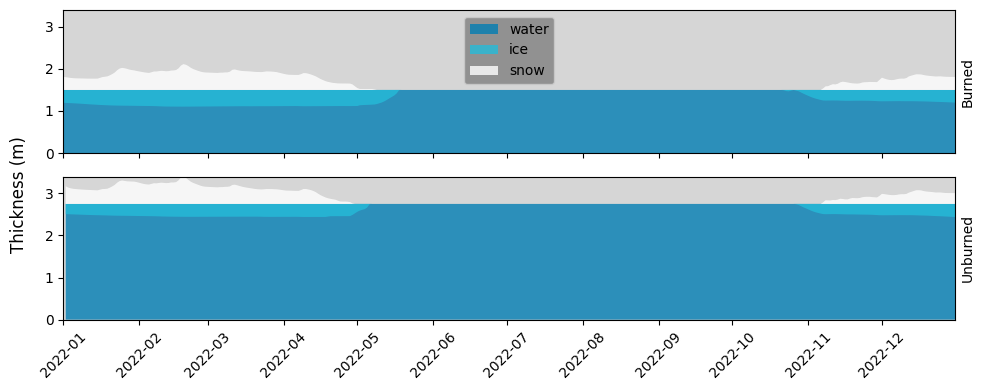

In [17]:
fig, axes = plt.subplots(2,1, figsize=(10,4), sharex=True, sharey=True)


axes[0].fill_between(layers_burned['Date'], layers_burned['water layer thickness, m'] - layers_burned['mean_mixed_layer_thickness'], layers_burned['water layer thickness, m'],  
                facecolor ='red', alpha = 0.8)
axes[0].fill_between(layers_burned['Date'], 0, layers_burned['water layer thickness, m'],  
                facecolor ='#027eb3', alpha = 0.8, label='water')
axes[0].fill_between(layers_burned['Date'], layers_burned['water layer thickness, m']-layers_burned['ice layer thickness,   m'], layers_burned['water layer thickness, m'],  
                facecolor ='#25bbd9', alpha = 0.8, label='ice')
axes[0].fill_between(layers_burned['Date'], layers_burned['water layer thickness, m'], layers_burned['snow layer thickness,  m'] + layers_burned['water layer thickness, m'],  
                facecolor ='white', alpha = 0.8, label='snow')
axes[0].fill_between(layers_burned['Date'], layers_burned['water layer thickness, m'] - layers_burned['mean_mixed_layer_thickness'], layers_burned['water layer thickness, m'],  
                facecolor ='red', alpha = 0.8)
axes[0].set_facecolor('#d6d6d6')
#axes[0].set_ylim(0,2.3)

axes[1].fill_between(layers_unburned['Date'], layers_unburned['water layer thickness, m'] - layers_unburned['mean_mixed_layer_thickness'], layers_unburned['water layer thickness, m'],  
                facecolor ='red', alpha = 0.8)
axes[1].fill_between(layers_unburned['Date'], 0, layers_unburned['water layer thickness, m'],  
                facecolor ='#027eb3', alpha = 0.8)
axes[1].fill_between(layers_unburned['Date'], layers_unburned['water layer thickness, m']-layers_unburned['ice layer thickness,   m'], layers_unburned['water layer thickness, m'],  
                facecolor ='#25bbd9', alpha = 0.8)
axes[1].fill_between(layers_unburned['Date'], layers_unburned['water layer thickness, m'], layers_unburned['snow layer thickness,  m'] + layers_unburned['water layer thickness, m'],  
                facecolor ='white', alpha = 0.8)
axes[1].fill_between(layers_unburned['Date'], layers_unburned['water layer thickness, m'] - layers_unburned['mean_mixed_layer_thickness'], layers_unburned['water layer thickness, m'],  
                facecolor ='red', alpha = 0.8)
axes[1].set_facecolor('#d6d6d6')
axes[0].legend(loc='upper center', facecolor = 'grey')

axes[0].set_ylabel('Burned')
axes[0].yaxis.set_label_position("right")

axes[1].set_ylabel('Unburned')
axes[1].yaxis.set_label_position("right")

plt.ylim(0, 3.4)
plt.xticks(rotation=45)
plt.xlim(pd.to_datetime('2022-01-01'),pd.to_datetime('2022-12-31'))
fig.supylabel('Thickness (m)')
fig.tight_layout()

plt.savefig('YKD-SA/figures/SA_layers.jpg', dpi=300)

In [18]:
layers_burned.loc[layers_burned['Date']=='2022-01-02']

,Date,"water layer thickness, m","ice layer thickness, m","snow layer thickness, m",mean_mixed_layer_thickness,mean_lower_layer_thickness,ice_layer_height,snow_layer_height
184,2022-01-02,1.5,0.3089,0.3031,0.0,0.0,1.8089,2.112


In [19]:
unburned_vars_df['run_name'].unique()

array([0])

In [20]:
water_data_burned = burned_vars_df.loc[(burned_vars_df['run_name']==0) & (burned_vars_df['t_water']!=-999) & (burned_vars_df['depth']==-1)][['Date', 't_water', 'WaterTemp_meas_degC', 'depth']].groupby(by='Date').mean().dropna()
water_data_unburned = unburned_vars_df.loc[(unburned_vars_df['run_name']==0) & (unburned_vars_df['t_water']!=-999) & (unburned_vars_df['depth']==-1)][['Date', 't_water', 'WaterTemp_meas_degC', 'depth']].groupby(by='Date').mean().dropna()

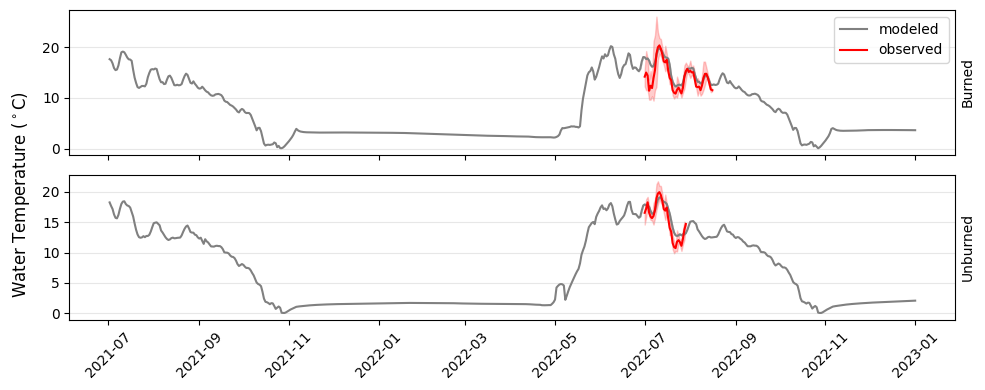

In [21]:
fig, axes = plt.subplots(2,1, figsize=(10,4), sharex=True)

sns.lineplot(data= burned_vars_df.loc[(burned_vars_df['run_name']==0)&(burned_vars_df['t_water']!=-999)& (burned_vars_df['depth']==-1)], 
             x='Date', y='t_water', label='modeled', ax=axes[0], color='grey')
sns.lineplot(data=burned_vars_df, x='Date', y='WaterTemp_meas_degC', label='observed', ax=axes[0], errorbar='pi', color='red')
#sns.scatterplot(data=burned_vars_df, x='Date', y='WaterTemp_meas_degC', ax=axes[0])

sns.lineplot(data= unburned_vars_df.loc[(unburned_vars_df['run_name']==0)&(unburned_vars_df['t_water']!=-999)& (unburned_vars_df['depth']==-1)], 
             x='Date', y='t_water', ax=axes[1], color='grey')
sns.lineplot(data=unburned_vars_df, x='Date', y='WaterTemp_meas_degC', ax=axes[1], errorbar='pi', color='red')
#sns.scatterplot(data=unburned_vars_df, x='Date', y='WaterTemp_meas_degC', ax=axes[1])



axes[0].set_ylabel('Burned')
axes[0].yaxis.set_label_position("right")
axes[0].grid(axis='y', alpha=0.3)

axes[1].set_ylabel('Unburned')
axes[1].yaxis.set_label_position("right")
axes[1].grid(axis='y', alpha=0.3)

axes[1].set_xlabel('')

plt.xticks(rotation=45)
fig.supylabel('Water Temperature ($^\circ$C)')
fig.tight_layout()

plt.savefig('YKD-SA/figures/SA_twater.jpg', dpi=300)

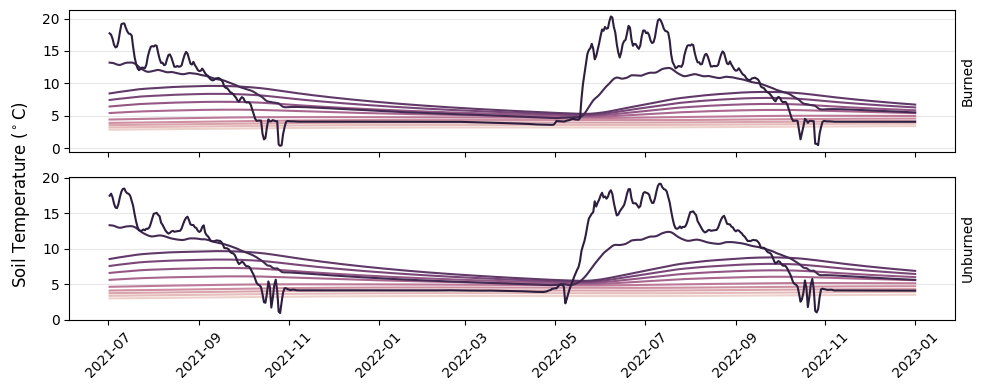

In [22]:
fig, axes = plt.subplots(2,1, figsize=(10,4), sharex=True)

sns.lineplot(data= burned_soil_temps_df.loc[(burned_soil_temps_df['run_name']==0)&(burned_soil_temps_df['t_soil']!=-999)], 
             x='Date', y='t_soil', label='modeled', ax=axes[0], hue='depth', legend=False)

sns.lineplot(data= unburned_soil_temps_df.loc[(unburned_soil_temps_df['run_name']==0)&(unburned_soil_temps_df['t_soil']!=-999)], 
             x='Date', y='t_soil', label='modeled', ax=axes[1], hue='depth', legend=False)

axes[0].set_ylabel('Burned')
axes[0].yaxis.set_label_position("right")
axes[0].grid(axis='y', alpha=0.3)

axes[1].set_ylabel('Unburned')
axes[1].yaxis.set_label_position("right")
axes[1].grid(axis='y', alpha=0.3)

axes[1].set_xlabel('')

plt.xticks(rotation=45)
fig.supylabel('Soil Temperature ($^\circ$C)')
fig.tight_layout()

plt.savefig('YKD-SA/figures/SA_tsoil.jpg', dpi=300)

In [23]:
burned_vars_df

,year,month,day,hour,integration_time,depth,t_water,Date,co2_water,ch4_water,...,dD (VSMOW),a250,A254,a350,a375,S_275_295,S_R,SUVA,CH4_mol_m3,DO_mol_m3
0,2021,7,2,12.0,1.0,-0.00,17.530079,2021-07-02,14.688313,0.021591,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2021,7,2,12.0,1.0,-0.05,17.624932,2021-07-02,14.618406,0.024584,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2021,7,2,12.0,1.0,-0.10,17.631551,2021-07-02,14.618547,0.024596,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2021,7,2,12.0,1.0,-0.15,17.637013,2021-07-02,14.620265,0.024532,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2021,7,2,12.0,1.0,-0.20,17.641906,2021-07-02,14.623198,0.024402,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51301,2023,1,1,12.0,549.0,-1.20,4.007449,2023-01-01,199.682726,430.612630,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
51302,2023,1,1,12.0,549.0,-1.40,4.020848,2023-01-01,199.661192,430.946488,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
51303,2023,1,1,12.0,549.0,-1.50,4.080198,2023-01-01,199.564511,433.931294,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
51304,2023,1,1,12.0,549.0,-2.00,-999.000000,2023-01-01,-999.000000,-999.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


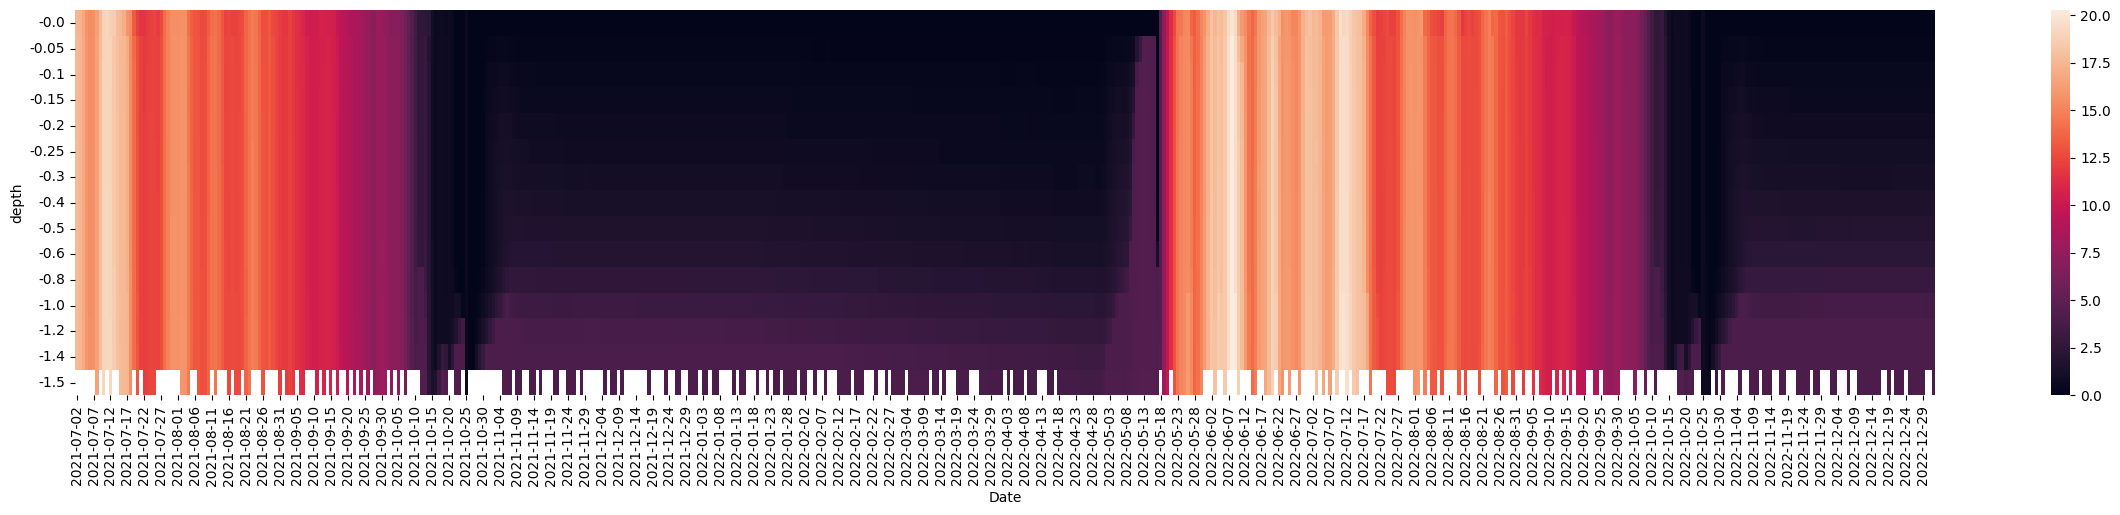

In [24]:
pd.plotting.register_matplotlib_converters()
burned_water_temps_df_filt=burned_vars_df.loc[(burned_vars_df['run_name']==0)&(burned_vars_df['t_water']!=-999)][['Date', 'depth', 't_water']].groupby(by=['Date', 'depth']).mean()
burned_water_temps_df_filt = burned_water_temps_df_filt.reset_index()
burned_water_temps_df_filt['Date'] = pd.to_datetime(burned_water_temps_df_filt['Date'])
burned_water_temps_df_filt['Date'] = burned_water_temps_df_filt['Date'].dt.date


pivot = burned_water_temps_df_filt.pivot(index='depth', columns='Date', values='t_water')
fig, ax = plt.subplots(1,1,figsize=(30,5))

sns.heatmap(pivot, cmap='rocket', ax=ax)

plt.gca().invert_yaxis()

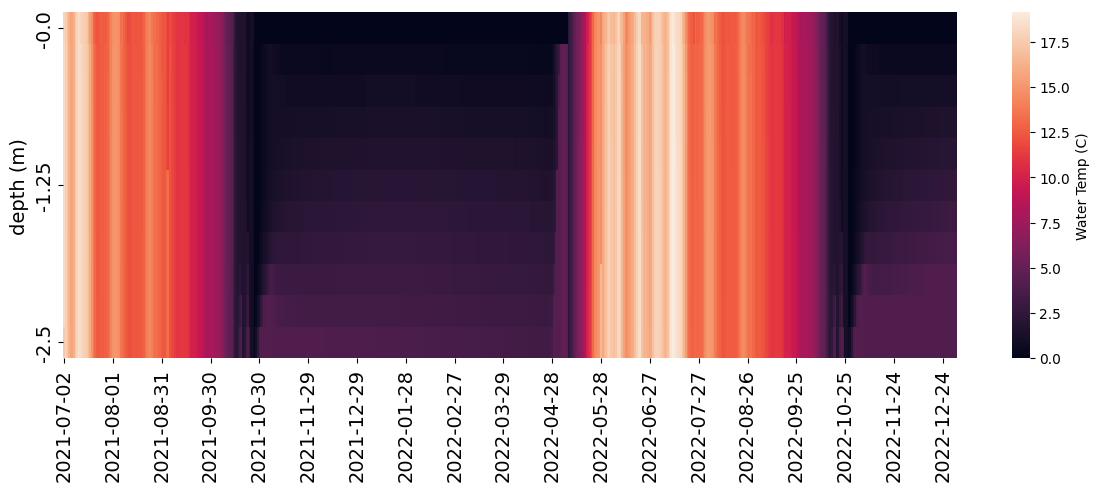

In [25]:
pd.plotting.register_matplotlib_converters()

unburned_water_temps_df_filt=unburned_vars_df.loc[(unburned_vars_df['run_name']==0)&(unburned_vars_df['t_water']!=-999)&(unburned_vars_df['depth']>-2.75)][['Date', 'depth', 't_water']].groupby(by=['Date', 'depth']).mean()
unburned_water_temps_df_filt = unburned_water_temps_df_filt.reset_index()
unburned_water_temps_df_filt['Date'] = pd.to_datetime(unburned_water_temps_df_filt['Date'])
unburned_water_temps_df_filt['Date'] = unburned_water_temps_df_filt['Date'].dt.date


pivot = unburned_water_temps_df_filt.pivot(index='depth', columns='Date', values='t_water')
fig, ax = plt.subplots(1,1,figsize=(12,5))

hmap = sns.heatmap(pivot, cmap='rocket', ax=ax, xticklabels=30,yticklabels=5, cbar_kws = {'label':'Water Temp (C)'})

plt.ylabel('depth (m)', fontsize=14)
plt.xlabel('')
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)




plt.gca().invert_yaxis()
fig.tight_layout()
plt.savefig('YKD-SA/figures/SA_twater_unburned_profile.jpg', dpi=300)

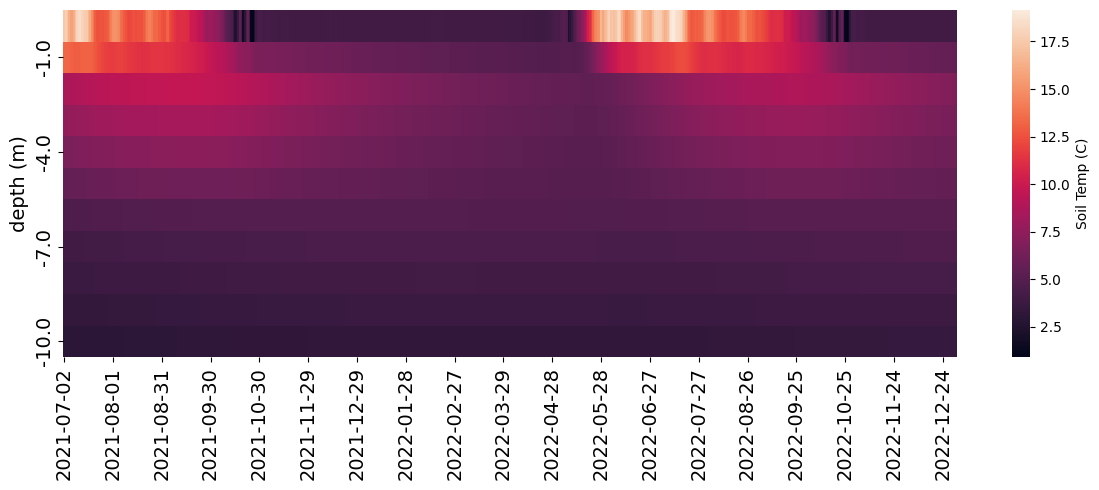

In [26]:
pd.plotting.register_matplotlib_converters()
unburned_soil_temps_df_filt=unburned_soil_temps_df.loc[(unburned_soil_temps_df['run_name']==0)&(unburned_soil_temps_df['t_soil']!=-999)][['Date', 'depth', 't_soil']]
unburned_soil_temps_df_filt['Date'] = pd.to_datetime(unburned_soil_temps_df_filt['Date'])
unburned_soil_temps_df_filt['Date'] = unburned_soil_temps_df_filt['Date'].dt.date

pivot = unburned_soil_temps_df_filt.pivot(index='depth', columns='Date', values='t_soil')
fig, ax = plt.subplots(1,1,figsize=(12,5))

sns.heatmap(pivot, cmap='rocket', ax=ax, xticklabels=30, yticklabels=3, cbar_kws = {'label':'Soil Temp (C)'})
plt.ylabel('depth (m)', fontsize=14)
plt.xlabel('')
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.gca().invert_yaxis()

fig.tight_layout()
plt.savefig('YKD-SA/figures/SA_tsoil_unburned_profile.jpg', dpi=300)



In [27]:
burned_vars_df[(burned_vars_df['t_water']!=-999) & (burned_vars_df['year']==2022) & (burned_vars_df['month']==1) & (burned_vars_df['day']==1)]

,year,month,day,hour,integration_time,depth,t_water,Date,co2_water,ch4_water,...,dD (VSMOW),a250,A254,a350,a375,S_275_295,S_R,SUVA,CH4_mol_m3,DO_mol_m3
3111,2022,1,1,12.0,184.0,-0.00,0.000000,2022-01-01,190.374527,127.846280,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3112,2022,1,1,12.0,184.0,-0.05,0.167715,2022-01-01,190.106669,128.970795,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3113,2022,1,1,12.0,184.0,-0.10,0.334043,2022-01-01,189.837751,131.037568,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3114,2022,1,1,12.0,184.0,-0.15,0.498904,2022-01-01,189.569753,133.266798,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3115,2022,1,1,12.0,184.0,-0.20,0.661880,2022-01-01,189.304830,135.132222,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3116,2022,1,1,12.0,184.0,-0.25,0.823180,2022-01-01,189.043438,136.447585,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3117,2022,1,1,12.0,184.0,-0.30,0.982749,2022-01-01,188.785533,138.150490,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3118,2022,1,1,12.0,184.0,-0.40,1.296154,2022-01-01,188.276159,141.387312,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3119,2022,1,1,12.0,184.0,-0.50,1.607012,2022-01-01,187.770491,133.253863,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3120,2022,1,1,12.0,184.0,-0.60,1.915910,2022-01-01,187.377827,127.533256,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
burned_soil_temps_df.loc[(burned_soil_temps_df['run_name']==0)&(burned_soil_temps_df['t_soil']!=-999)&(burned_soil_temps_df['Date']=='2022-01-01')]

,year,month,day,hour,integration_time,depth,t_soil,Date,run_name
2013,2022,1,1,12.0,184.0,-0.0,4.0948,2022-01-01,0
2014,2022,1,1,12.0,184.0,-1.0,5.7470,2022-01-01,0
2015,2022,1,1,12.0,184.0,-2.0,7.1245,2022-01-01,0
2016,2022,1,1,12.0,184.0,-3.0,6.5415,2022-01-01,0
2017,2022,1,1,12.0,184.0,-4.0,5.9585,2022-01-01,0
2018,2022,1,1,12.0,184.0,-5.0,5.3755,2022-01-01,0
2019,2022,1,1,12.0,184.0,-6.0,4.7925,2022-01-01,0
2020,2022,1,1,12.0,184.0,-7.0,4.3551,2022-01-01,0
2021,2022,1,1,12.0,184.0,-8.0,3.9662,2022-01-01,0
2022,2022,1,1,12.0,184.0,-9.0,3.5773,2022-01-01,0


In [29]:
def get_performance(df, model_var, obs_var):
    runs = []
    var_mae = []
    df.loc[df[obs_var]==-999, obs_var] = np.nan
    for run in df['run_name'].unique():
        runs.append(run)
        var_mae.append(mean_absolute_error(df.loc[(df['run_name']==run) & (~df[obs_var].isna()), obs_var], df.loc[(df['run_name']==run) & (~df[obs_var].isna()),model_var]))
    
    df_performance = pd.DataFrame({'run_name': runs, f'{model_var}_mae': var_mae})

    return df_performance


In [30]:
#burned_vars_df = burned_vars_df.loc[burned_vars_df['depth']==-1.0]

df_co2_comp = get_performance(burned_vars_df.loc[burned_vars_df['depth']==-1.0], 'co2_water', 'CO2_mol_m3')
co2_top_10 = df_co2_comp.sort_values(by='co2_water_mae')[:10]
co2_top = df_co2_comp.sort_values(by='co2_water_mae')[:1]

df_co2_comp_ub = get_performance(unburned_vars_df.loc[unburned_vars_df['depth']==-1.0], 'co2_water', 'CO2_mol_m3')
co2_top_10_ub = df_co2_comp_ub.sort_values(by='co2_water_mae')[:10]
co2_top_ub = df_co2_comp_ub.sort_values(by='co2_water_mae')[:1]

In [31]:
df_ch4_comp = get_performance(burned_vars_df.loc[burned_vars_df['depth']==-1.0], 'ch4_water', 'CH4_mol_m3')
ch4_top_10 = df_ch4_comp.sort_values(by='ch4_water_mae')[:10]
ch4_top = df_ch4_comp.sort_values(by='ch4_water_mae')[:1]

df_ch4_comp_ub = get_performance(unburned_vars_df.loc[unburned_vars_df['depth']==-1.0], 'ch4_water', 'CH4_mol_m3')
ch4_top_10_ub = df_ch4_comp_ub.sort_values(by='ch4_water_mae')[:10]
ch4_top_ub = df_ch4_comp_ub.sort_values(by='ch4_water_mae')[:1]

In [32]:
df_o2_comp = get_performance(burned_vars_df.loc[burned_vars_df['depth']==-1.0], 'o2_water', 'DO_mg_L')
o2_top_10 = df_o2_comp.sort_values(by='o2_water_mae')[:10]
o2_top = df_o2_comp.sort_values(by='o2_water_mae')[:1]

df_o2_comp_ub = get_performance(unburned_vars_df.loc[unburned_vars_df['depth']==-1.0], 'o2_water', 'DO_mg_L')
o2_top_10_ub = df_o2_comp_ub.sort_values(by='o2_water_mae')[:10]
o2_top_ub = df_o2_comp_ub.sort_values(by='o2_water_mae')[:1]

In [33]:
df_twater_comp = get_performance(burned_vars_df.loc[burned_vars_df['depth']==-1.0], 't_water', 'WaterTemp_meas_degC')

df_twater_comp_ub = get_performance(unburned_vars_df.loc[unburned_vars_df['depth']==-1.0], 't_water', 'WaterTemp_meas_degC')

In [80]:
df_twater_comp

,run_name,t_water_mae
0,0,1.730562


In [81]:
print('burned water temp r2: {}'.format(r2_score(water_data_burned['WaterTemp_meas_degC'], water_data_burned['t_water'])))
print('burned water temp MAE: {}'.format(mean_absolute_error(water_data_burned['WaterTemp_meas_degC'], water_data_burned['t_water'])))

print('unburned water temp r2: {}'.format(r2_score(water_data_unburned['WaterTemp_meas_degC'], water_data_unburned['t_water'])))
print('unburned water temp MAE: {}'.format(mean_absolute_error(water_data_unburned['WaterTemp_meas_degC'], water_data_unburned['t_water'])))

burned water temp r2: 0.4869210422606418
burned water temp MAE: 1.3033601995560464
unburned water temp r2: 0.792361526142858
unburned water temp MAE: 1.1261125002134653


In [35]:
print('burned mae:\nco2: {}\nch4: {}\no2: {}'.format(co2_top['co2_water_mae'].values[0], ch4_top['ch4_water_mae'].values[0], o2_top['o2_water_mae'].values[0]))
print('unburned mae:\nco2: {}\nch4: {}\no2: {}'.format(co2_top_ub['co2_water_mae'].values[0], ch4_top_ub['ch4_water_mae'].values[0], o2_top_ub['o2_water_mae'].values[0]))

burned mae:
co2: 8.081079831632415
ch4: 0.38759384078545717
o2: 0.6462622850810807
unburned mae:
co2: 16.366292387794182
ch4: 0.1786272950535327
o2: 6.573650965648649


In [36]:
co2_data_burned = burned_vars_df.loc[(burned_vars_df['run_name']==0) & (burned_vars_df['t_water']!=-999) & (burned_vars_df['depth']==-1)][['Date', 'co2_water', 'CO2_mol_m3', 'depth']].groupby(by='Date').mean().dropna()
co2_data_unburned = unburned_vars_df.loc[(unburned_vars_df['run_name']==co2_top_ub['run_name'].values[0]) & (unburned_vars_df['t_water']!=-999) & (unburned_vars_df['depth']==-1)][['Date', 'co2_water', 'CO2_mol_m3', 'depth']].groupby(by='Date').mean().dropna()

In [37]:
print('burned water co2 r2: {}'.format(r2_score(co2_data_burned['CO2_mol_m3'], co2_data_burned['co2_water'])))
print('unburned water co2 r2: {}'.format(r2_score(co2_data_unburned['CO2_mol_m3'], co2_data_unburned['co2_water'])))
#0.6054210961196094

burned water co2 r2: 0.3238314114844044
unburned water co2 r2: 0.632294983306614


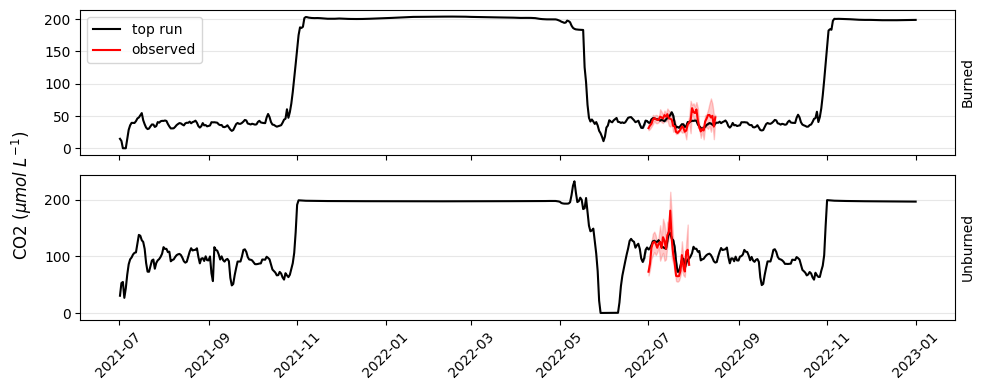

In [38]:
fig, axes = plt.subplots(2,1, figsize=(10,4), sharex=True)

sns.lineplot(data= burned_vars_df[(burned_vars_df['co2_water']!=-999 ) & (burned_vars_df['depth']==-1) & burned_vars_df['run_name'].isin(co2_top_10['run_name'])], 
             x='Date', y='co2_water', hue = 'run_name', legend=False, linewidth=0.3, ax=axes[0])

#sns.lineplot(data= burned_vars_df[(burned_vars_df['co2_water']!=-999 ) & (burned_vars_df['depth']==-1)], 
#             x='Date', y='co2_water', hue = 'run_name', legend=False, linewidth=0.3, ax=axes[0])
sns.lineplot(data= burned_vars_df[(burned_vars_df['co2_water']!=-999 )  & (burned_vars_df['depth']==-1) & burned_vars_df['run_name'].isin(co2_top['run_name'])], 
             x='Date', y='co2_water', label='top run', color='black', ax=axes[0])
sns.lineplot(data= burned_co2_obs, x='Date', y='CO2_mol_m3', label='observed', color='red', ax=axes[0], errorbar='pi')

axes[0].set_ylabel('Burned')
axes[0].yaxis.set_label_position("right")
axes[0].grid(axis='y', alpha=0.3)

sns.lineplot(data= unburned_vars_df[(unburned_vars_df['co2_water']!=-999 ) & (unburned_vars_df['depth']==-1) & unburned_vars_df['run_name'].isin(co2_top_10_ub['run_name'])], 
             x='Date', y='co2_water', hue = 'run_name', legend=False, linewidth=0.3, ax=axes[1])
#sns.lineplot(data= unburned_vars_df[(unburned_vars_df['co2_water']!=-999 ) & (unburned_vars_df['depth']==-1) & (unburned_vars_df['run_name']==69)], 
#             x='Date', y='co2_water', legend=False, linewidth=0.3, ax=axes[1])
sns.lineplot(data= unburned_vars_df[(unburned_vars_df['co2_water']!=-999 )  & (unburned_vars_df['depth']==-1) & unburned_vars_df['run_name'].isin(co2_top_ub['run_name'])], 
             x='Date', y='co2_water', color='black', ax=axes[1])
sns.lineplot(data= unburned_co2_obs, x='Date', y='CO2_mol_m3', color='red', ax=axes[1], errorbar='pi')

plt.xticks(rotation=45)
#axes[0].set_ylim(0,180)

axes[1].set_ylabel('Unburned')
axes[1].yaxis.set_label_position('right')
axes[1].grid(axis='y', alpha=0.3)

axes[1].set_xlabel('')

fig.supylabel(u'CO2 ($\u03bcmol$ $L^{-1}$)')
fig.tight_layout()

plt.savefig('YKD-SA/figures/SA_co2.jpg', dpi=300)

#axes[1].set_ylim(0,220)
#axes[1].set_xlim(pd.to_datetime('2022-05-01'), pd.to_datetime('2022-11-01'))

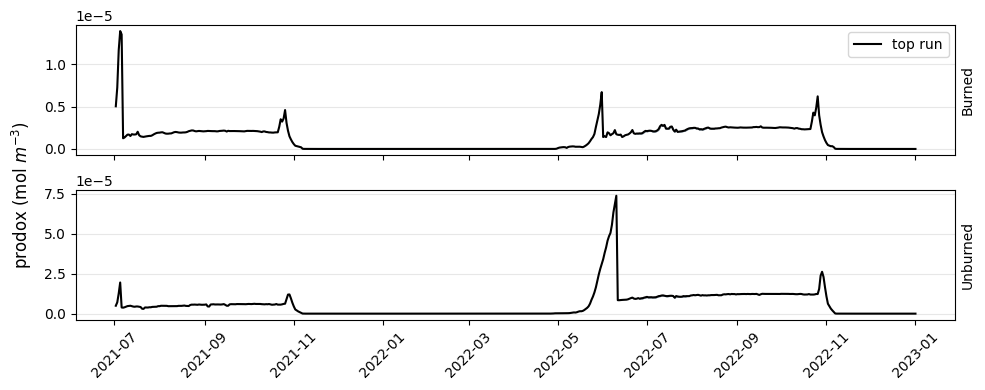

In [39]:
fig, axes = plt.subplots(2,1, figsize=(10,4), sharex=True)

sns.lineplot(data= burned_vars_df[(burned_vars_df['prodox']!=-999 ) & (burned_vars_df['depth']==-1) & burned_vars_df['run_name'].isin(co2_top_10['run_name'])], 
             x='Date', y='prodox', hue = 'run_name', legend=False, linewidth=0.3, ax=axes[0])

sns.lineplot(data= burned_vars_df[(burned_vars_df['prodox']!=-999 )  & (burned_vars_df['depth']==-1) & burned_vars_df['run_name'].isin(co2_top['run_name'])], 
             x='Date', y='prodox', label='top run', color='black', ax=axes[0])

axes[0].set_ylabel('Burned')
axes[0].yaxis.set_label_position("right")
axes[0].grid(axis='y', alpha=0.3)

sns.lineplot(data= unburned_vars_df[(unburned_vars_df['prodox']!=-999 ) & (unburned_vars_df['depth']==-1) & unburned_vars_df['run_name'].isin(co2_top_10_ub['run_name'])], 
             x='Date', y='prodox', hue = 'run_name', legend=False, linewidth=0.3, ax=axes[1])
sns.lineplot(data= unburned_vars_df[(unburned_vars_df['prodox']!=-999 )  & (unburned_vars_df['depth']==-1) & unburned_vars_df['run_name'].isin(co2_top_ub['run_name'])], 
             x='Date', y='prodox', color='black', ax=axes[1])
#sns.lineplot(data= unburned_vars_df[(unburned_vars_df['prodox']!=-999 )  & (unburned_vars_df['depth']==-1) & (unburned_vars_df['run_name']==22)], 
#             x='Date', y='prodox', color='black', ax=axes[1])

plt.xticks(rotation=45)

axes[1].set_ylabel('Unburned')
axes[1].yaxis.set_label_position('right')
axes[1].grid(axis='y', alpha=0.3)

axes[1].set_xlabel('')
#axes[1].set_ylim(0,1e-5)
fig.supylabel(u'prodox (mol $m^{-3}$)')
fig.tight_layout()

plt.savefig('YKD-SA/figures/SA_prodox.jpg', dpi=300)

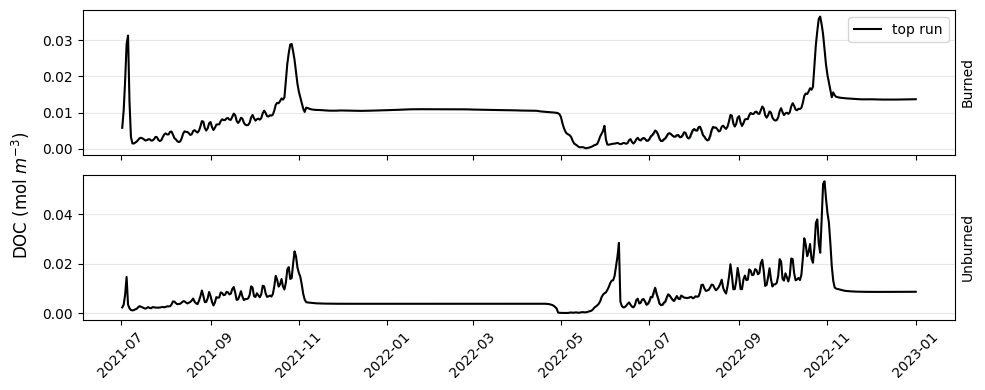

In [40]:
fig, axes = plt.subplots(2,1, figsize=(10,4), sharex=True)

sns.lineplot(data= burned_vars_df[(burned_vars_df['doc_water']!=-999 ) & (burned_vars_df['depth']==-1) & burned_vars_df['run_name'].isin(co2_top_10['run_name'])], 
             x='Date', y='doc_water', hue = 'run_name', legend=False, linewidth=0.3, ax=axes[0])

#sns.lineplot(data= burned_vars_df[(burned_vars_df['co2_water']!=-999 ) & (burned_vars_df['depth']==-1)], 
#             x='Date', y='co2_water', hue = 'run_name', legend=False, linewidth=0.3, ax=axes[0])
sns.lineplot(data= burned_vars_df[(burned_vars_df['doc_water']!=-999 )  & (burned_vars_df['depth']==-1) & burned_vars_df['run_name'].isin(co2_top['run_name'])], 
             x='Date', y='doc_water', label='top run', color='black', ax=axes[0])
#sns.lineplot(data= burned_co2_obs, x='Date', y='CO2_mol_m3', label='observed', color='red', ax=axes[0], errorbar='pi')

axes[0].set_ylabel('Burned')
axes[0].yaxis.set_label_position("right")
axes[0].grid(axis='y', alpha=0.3)

sns.lineplot(data= unburned_vars_df[(unburned_vars_df['doc_water']!=-999 ) & (unburned_vars_df['depth']==-1) & unburned_vars_df['run_name'].isin(co2_top_10_ub['run_name'])], 
             x='Date', y='doc_water', hue = 'run_name', legend=False, linewidth=0.3, ax=axes[1])
sns.lineplot(data= unburned_vars_df[(unburned_vars_df['doc_water']!=-999 )  & (unburned_vars_df['depth']==-1) & unburned_vars_df['run_name'].isin(co2_top_ub['run_name'])], 
             x='Date', y='doc_water', color='black', ax=axes[1])
#sns.lineplot(data= unburned_co2_obs, x='Date', y='CO2_mol_m3', color='red', ax=axes[1], errorbar='pi')

plt.xticks(rotation=45)
#axes[1].set_ylim(0,0.1)

axes[1].set_ylabel('Unburned')
axes[1].yaxis.set_label_position('right')
axes[1].grid(axis='y', alpha=0.3)

axes[1].set_xlabel('')

fig.supylabel(u'DOC (mol $m^{-3}$)')
fig.tight_layout()

plt.savefig('YKD-SA/figures/SA_doc.jpg', dpi=300)

In [41]:
burned_vars_df.loc[burned_vars_df['depth']==-1][['t_water','co2_water', 'ch4_water', 'o2_water', 'doc_water']].mean()

t_water      14.053460
co2_water    53.724703
ch4_water    27.397109
o2_water      9.095780
doc_water     0.004784
dtype: float64

In [42]:
burned_vars_df.loc[burned_vars_df['depth']==-1][['t_water','co2_water', 'ch4_water', 'o2_water', 'doc_water']].std()

t_water       4.438548
co2_water    45.425625
ch4_water    97.398811
o2_water      2.909303
doc_water     0.003286
dtype: float64

In [43]:
unburned_vars_df.loc[unburned_vars_df['depth']==-1][['t_water','co2_water', 'ch4_water', 'o2_water', 'doc_water']].mean()

t_water       13.734471
co2_water    118.804156
ch4_water     10.182102
o2_water       6.510848
doc_water      0.006379
dtype: float64

In [44]:
unburned_vars_df.loc[unburned_vars_df['depth']==-1][['t_water','co2_water', 'ch4_water', 'o2_water', 'doc_water']].std()

t_water       5.514749
co2_water    36.412846
ch4_water    31.990759
o2_water      2.796773
doc_water     0.003865
dtype: float64

In [45]:
#sns.lineplot(data= burned_vars_df[(burned_vars_df['doc_water']!=-999) & (burned_vars_df['depth']==-1)], x='Date', y='doc_water', hue = 'run_name', legend=False, linewidth=0.3)
#sns.scatterplot(data=ch4_obs[ch4_obs['sample']=='15B_FP'], x='Date', y='TOC (mg/L)', label='observed', color='red')
#plt.xticks(rotation=45)


In [46]:
burned_vars_df.columns

Index(['year', 'month', 'day', 'hour', 'integration_time', 'depth', 't_water',
       'Date', 'co2_water', 'ch4_water', 'o2_water', 'doc_water', 'pocl_water',
       'pocd_water', 'phosph_water', 'prodox', 'poc_water', 'run_name',
       'datetime', 'Time', 'Battery_Voltage_Avg', 'PTemp_Avg_degC',
       'CO2_meas_ppm', 'CO2_meas_RA_ppm', 'WaterTemp_meas_degC', 'PAR',
       'CO2_mol_m3', 'sample', 'coords_west', 'coords_east', 'system_type',
       'burn_history', 'burn_year', 'CH4_ppm', 'CO2_ppm', 'CN_filt_vol',
       'temp_C', 'pressure_atm', 'DO_mg_L', 'cond_uS_cm', 'pH', 'ORP',
       'TOC (mg/L)', 'TN (mg/L)', 'd18O (VSMOW)', 'dD (VSMOW)', 'a250', 'A254',
       'a350', 'a375', 'S_275_295', 'S_R', 'SUVA', 'CH4_mol_m3', 'DO_mol_m3'],
      dtype='object')

In [47]:
burned_sample_comp = burned_vars_df.loc[(~burned_vars_df['CH4_mol_m3'].isna()) & (burned_vars_df['depth']==-1)][['Date', 'ch4_water', 'o2_water', 'DO_mg_L', 'CH4_mol_m3', 'depth']].groupby(by='Date').mean()
unburned_sample_comp = unburned_vars_df.loc[(~unburned_vars_df['CH4_mol_m3'].isna()) & (unburned_vars_df['depth']==-1)][['Date', 'ch4_water', 'o2_water', 'DO_mg_L', 'CH4_mol_m3', 'depth']].groupby(by='Date').mean()
burned_sample_comp['pond'] = 'burned' 
unburned_sample_comp['pond'] = 'unburned'
sample_comp = pd.concat([burned_sample_comp, unburned_sample_comp]).reset_index()

In [48]:
sample_comp_melt=pd.melt(sample_comp, id_vars=['Date', 'pond'])

In [49]:
palette= sns.color_palette(['#786F5F', '#C9BA9F'])

Text(0, 0.5, 'CH4 (umol/L)')

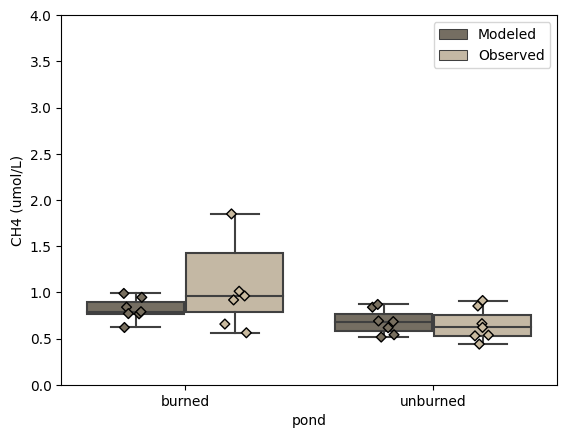

In [50]:
sns.boxplot(data=sample_comp_melt.loc[(sample_comp_melt['variable'] == 'ch4_water') | (sample_comp_melt['variable'] == 'CH4_mol_m3')], 
            x='pond', y='value', hue='variable', palette=palette)
sns.stripplot(data=sample_comp_melt.loc[(sample_comp_melt['variable'] == 'ch4_water') | (sample_comp_melt['variable'] == 'CH4_mol_m3')], 
            x='pond', y='value', hue='variable', dodge=True, marker="D", edgecolor="black", linewidth=1, legend=False, palette=palette)
plt.ylim(0,4)
L=plt.legend()
L.get_texts()[0].set_text('Modeled')
L.get_texts()[1].set_text('Observed')

plt.ylabel('CH4 (umol/L)')

Text(0, 0.5, 'O2 (mg/L)')

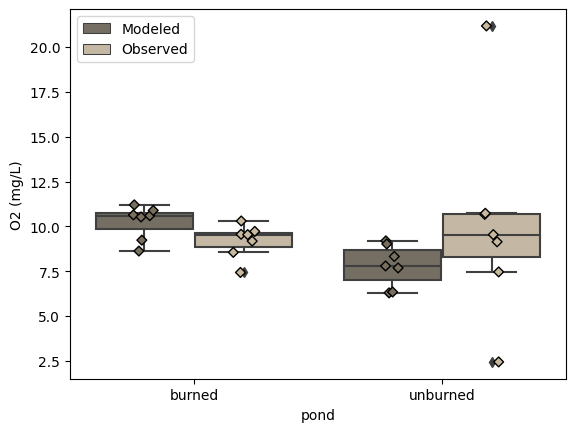

In [51]:
sns.boxplot(data=sample_comp_melt.loc[(sample_comp_melt['variable'] == 'o2_water') | (sample_comp_melt['variable'] == 'DO_mg_L')], 
            x='pond', y='value', hue='variable', palette=palette)
sns.stripplot(data=sample_comp_melt.loc[(sample_comp_melt['variable'] == 'o2_water') | (sample_comp_melt['variable'] == 'DO_mg_L')], 
            x='pond', y='value', hue='variable', dodge=True, marker="D", edgecolor="black", linewidth=1, legend=False, palette=palette)

L=plt.legend()
L.get_texts()[0].set_text('Modeled')
L.get_texts()[1].set_text('Observed')

plt.ylabel('O2 (mg/L)')

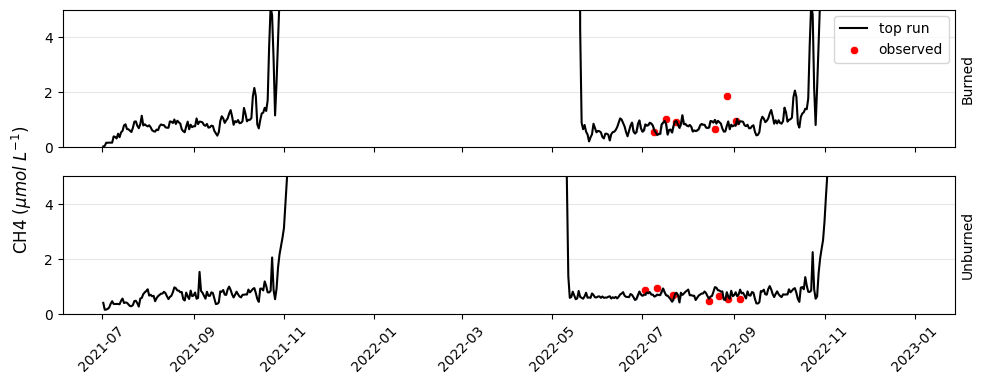

In [52]:
#sns.lineplot(data= burned_vars_df[(burned_vars_df['ch4_water']!=-999)  & (burned_vars_df['depth']==-1)], x='Date', y='ch4_water', hue = 'run_name', legend=False,linewidth=0.3)
fig, axes = plt.subplots(2,1, figsize=(10,4), sharex=True)

sns.lineplot(data = burned_vars_df[(burned_vars_df['ch4_water']!=-999 ) & (burned_vars_df['depth']==-1) & burned_vars_df['run_name'].isin(ch4_top_10['run_name'])], 
             x='Date', y='ch4_water', hue = 'run_name', legend=False, linewidth=0.3, ax=axes[0])
sns.lineplot(data= burned_vars_df[(burned_vars_df['ch4_water']!=-999 ) & (burned_vars_df['depth']==-1) & burned_vars_df['run_name'].isin(ch4_top['run_name'])], 
             x='Date', y='ch4_water', label='top run', color='black', ax=axes[0])
sns.scatterplot(data=ch4_obs[ch4_obs['sample']=='15B_FP'], x='Date', y='CH4_mol_m3', label='observed', color='red', ax=axes[0])

axes[0].set_ylim(0,5)
axes[0].set_ylabel('Burned')
axes[0].yaxis.set_label_position("right")
axes[0].grid(axis='y', alpha=0.3)

#sns.lineplot(data= unburned_vars_df[(unburned_vars_df['ch4_water']!=-999 ) & (unburned_vars_df['depth']==-1)], 
#             x='Date', y='ch4_water', hue = 'run_name', legend=False, linewidth=0.3, ax=axes[1])
sns.lineplot(data= unburned_vars_df[(unburned_vars_df['ch4_water']!=-999 ) & (unburned_vars_df['depth']==-1) & unburned_vars_df['run_name'].isin(co2_top_10_ub['run_name'])], 
             x='Date', y='ch4_water', hue = 'run_name', legend=False, linewidth=0.3, ax=axes[1])
sns.lineplot(data= unburned_vars_df[(unburned_vars_df['ch4_water']!=-999 ) & (unburned_vars_df['depth']==-1) & unburned_vars_df['run_name'].isin(co2_top_ub['run_name'])], 
             x='Date', y='ch4_water',  color='black', legend=False, ax=axes[1])
sns.scatterplot(data=ch4_obs[ch4_obs['sample']=='UB_FP'], x='Date', y='CH4_mol_m3', color='red', ax=axes[1])

axes[1].set_ylabel('Unburned')
axes[1].yaxis.set_label_position("right")
axes[1].grid(axis='y', alpha=0.3)
axes[1].set_xlabel('')
axes[1].set_ylim(0,5.0)

plt.xticks(rotation=45)
fig.supylabel(u'CH4 ($\u03bcmol$ $L^{-1}$)')
fig.tight_layout()

plt.savefig('YKD-SA/figures/SA_ch4.jpg', dpi=300)

In [53]:
burned_vars_df[(burned_vars_df['ch4_water']!=-999 ) & (burned_vars_df['depth']==-1) & burned_vars_df['run_name'].isin(ch4_top_10['run_name'])]

,year,month,day,hour,integration_time,depth,t_water,Date,co2_water,ch4_water,...,dD (VSMOW),a250,A254,a350,a375,S_275_295,S_R,SUVA,CH4_mol_m3,DO_mol_m3
11,2021,7,2,12.0,1.0,-1.0,17.672588,2021-07-02,14.715307,0.020998,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28,2021,7,3,12.0,2.0,-1.0,17.459211,2021-07-03,11.382117,0.044383,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
45,2021,7,4,12.0,3.0,-1.0,16.848107,2021-07-04,0.076970,0.155920,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
62,2021,7,5,12.0,4.0,-1.0,15.913503,2021-07-05,0.074466,0.153912,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
79,2021,7,6,12.0,5.0,-1.0,15.506072,2021-07-06,0.071268,0.160505,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51232,2022,12,28,12.0,545.0,-1.0,3.639514,2022-12-28,198.821775,327.607902,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
51249,2022,12,29,12.0,546.0,-1.0,3.637070,2022-12-29,198.861431,333.459984,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
51266,2022,12,30,12.0,547.0,-1.0,3.633745,2022-12-30,198.893968,338.954844,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
51283,2022,12,31,12.0,548.0,-1.0,3.629469,2022-12-31,198.916811,343.971101,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


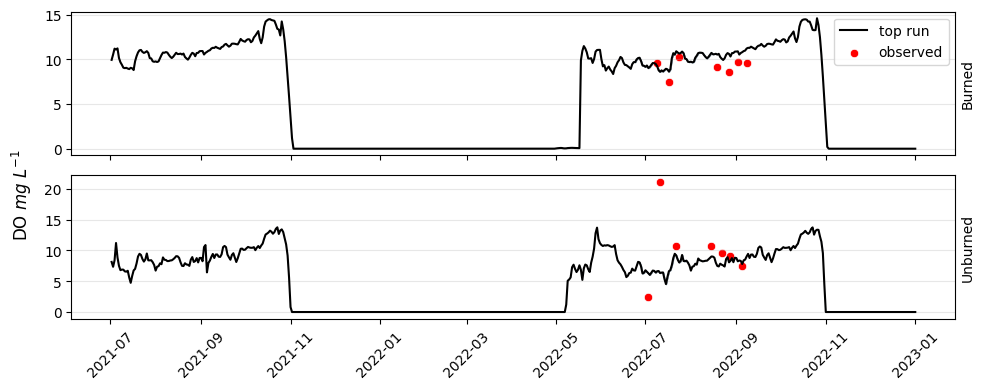

In [54]:
fig, axes = plt.subplots(2,1, figsize=(10,4), sharex=True)

sns.lineplot(data= burned_vars_df[(burned_vars_df['ch4_water']!=-999 ) & (burned_vars_df['depth']==-1.0) & burned_vars_df['run_name'].isin(o2_top_10['run_name'])], 
             x='Date', y='o2_water', hue = 'run_name', legend=False, linewidth=0.3, ax=axes[0])
sns.lineplot(data= burned_vars_df[(burned_vars_df['co2_water']!=-999 ) & (burned_vars_df['depth']==-1) & burned_vars_df['run_name'].isin(o2_top['run_name'])], 
             x='Date', y='o2_water', label='top run', color='black', ax=axes[0])
sns.scatterplot(data=ch4_obs[ch4_obs['sample']=='15B_FP'], x='Date', y='DO_mg_L', label='observed', color='red', ax=axes[0])
axes[0].set_ylabel('Burned')
axes[0].yaxis.set_label_position("right")
axes[0].grid(axis='y', alpha=0.3)

sns.lineplot(data= unburned_vars_df[(unburned_vars_df['ch4_water']!=-999 ) & (unburned_vars_df['depth']==-1.0) & unburned_vars_df['run_name'].isin(co2_top_10_ub['run_name'])],
             x='Date', y='o2_water', hue = 'run_name', legend=False, linewidth=0.3, ax=axes[1])
sns.lineplot(data= unburned_vars_df[(unburned_vars_df['co2_water']!=-999 ) & (unburned_vars_df['depth']==-1) & unburned_vars_df['run_name'].isin(co2_top_ub['run_name'])], 
             x='Date', y='o2_water', color='black', ax=axes[1])
sns.scatterplot(data=ch4_obs[ch4_obs['sample']=='UB_FP'], x='Date', y='DO_mg_L', color='red', ax=axes[1])
axes[1].set_ylabel('Unburned')
axes[1].yaxis.set_label_position("right")
axes[1].grid(axis='y', alpha=0.3)
axes[1].set_xlabel('')

plt.xticks(rotation=45)
fig.supylabel('DO $mg$ $L^{-1}$')
fig.tight_layout()

plt.savefig('YKD-SA/figures/SA_do.jpg', dpi=300)
#plt.ylim(0,10)

(array([18809., 18871., 18932., 18993., 19052., 19113., 19174., 19236.,
        19297., 19358.]),
 [Text(18809.0, 0, '2021-07'),
  Text(18871.0, 0, '2021-09'),
  Text(18932.0, 0, '2021-11'),
  Text(18993.0, 0, '2022-01'),
  Text(19052.0, 0, '2022-03'),
  Text(19113.0, 0, '2022-05'),
  Text(19174.0, 0, '2022-07'),
  Text(19236.0, 0, '2022-09'),
  Text(19297.0, 0, '2022-11'),
  Text(19358.0, 0, '2023-01')])

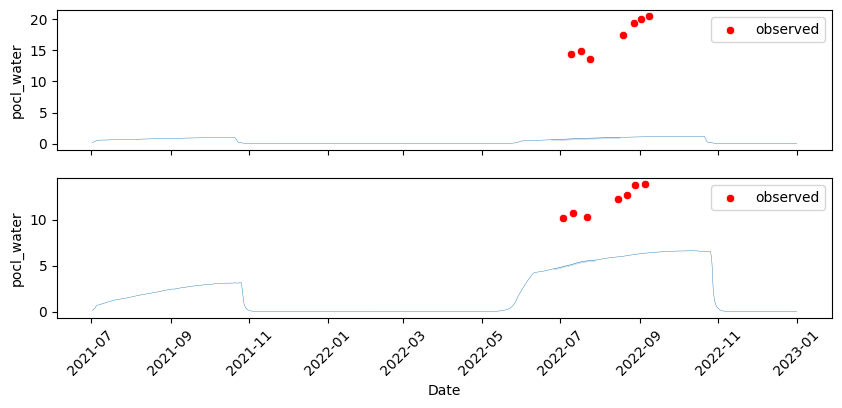

In [55]:
fig, axes = plt.subplots(2,1, figsize=(10,4), sharex=True)

sns.lineplot(data= burned_vars_df[(burned_vars_df['pocl_water']!=-999 ) & (burned_vars_df['depth']==-1) & burned_vars_df['run_name'].isin(o2_top_10['run_name'])], x='Date', y='pocl_water', hue = 'run_name', legend=False, linewidth=0.3, ax=axes[0])

sns.scatterplot(data=ch4_obs[ch4_obs['sample']=='15B_FP'], x='Date', y='TOC (mg/L)', label='observed', color='red', ax=axes[0])
plt.xticks(rotation=45)

sns.lineplot(data=unburned_vars_df[(unburned_vars_df['pocl_water']!=-999 ) & (unburned_vars_df['depth']==-1) & unburned_vars_df['run_name'].isin(o2_top_10_ub['run_name'])], x='Date', y='pocl_water', hue = 'run_name', legend=False, linewidth=0.3, ax=axes[1])

sns.scatterplot(data=ch4_obs[ch4_obs['sample']=='UB_FP'], x='Date', y='TOC (mg/L)', label='observed', color='red', ax=axes[1])
#axes[0].set_ylim(0,1)
#axes[1].set_ylim(0,1)
plt.xticks(rotation=45)

(array([18809., 18871., 18932., 18993., 19052., 19113., 19174., 19236.,
        19297., 19358.]),
 [Text(18809.0, 0, '2021-07'),
  Text(18871.0, 0, '2021-09'),
  Text(18932.0, 0, '2021-11'),
  Text(18993.0, 0, '2022-01'),
  Text(19052.0, 0, '2022-03'),
  Text(19113.0, 0, '2022-05'),
  Text(19174.0, 0, '2022-07'),
  Text(19236.0, 0, '2022-09'),
  Text(19297.0, 0, '2022-11'),
  Text(19358.0, 0, '2023-01')])

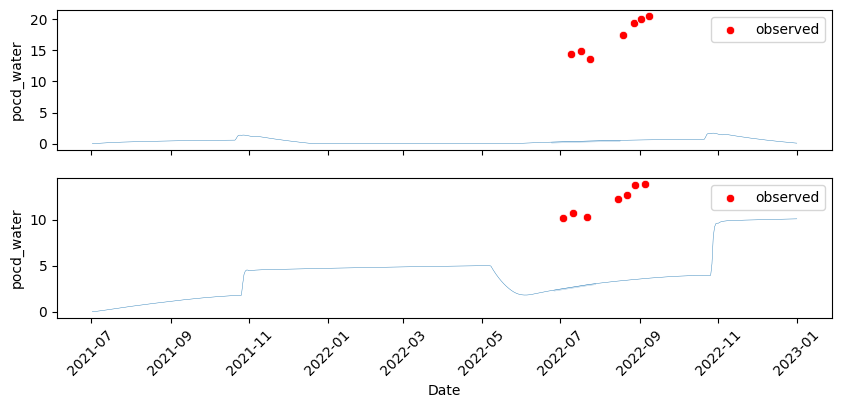

In [56]:
fig, axes = plt.subplots(2,1, figsize=(10,4), sharex=True)

sns.lineplot(data = burned_vars_df[(burned_vars_df['pocd_water']!=-999 ) & (burned_vars_df['depth']==-1.0) & burned_vars_df['run_name'].isin(o2_top_10['run_name'])], x='Date', y='pocd_water', hue = 'run_name', legend=False, linewidth=0.3, ax=axes[0])

sns.scatterplot(data = ch4_obs[ch4_obs['sample']=='15B_FP'], x='Date', y='TOC (mg/L)', label='observed', color='red', ax=axes[0])
plt.xticks(rotation=45)

sns.lineplot(data = unburned_vars_df[(unburned_vars_df['pocd_water']!=-999 ) & (unburned_vars_df['depth']==-1.0) & unburned_vars_df['run_name'].isin(co2_top_10_ub['run_name'])], x='Date', y='pocd_water', hue = 'run_name', legend=False, linewidth=0.3, ax=axes[1])

sns.scatterplot(data = ch4_obs[ch4_obs['sample']=='UB_FP'], x='Date', y='TOC (mg/L)', label='observed', color='red', ax=axes[1])
plt.xticks(rotation=45)

(0.0, 0.0005)

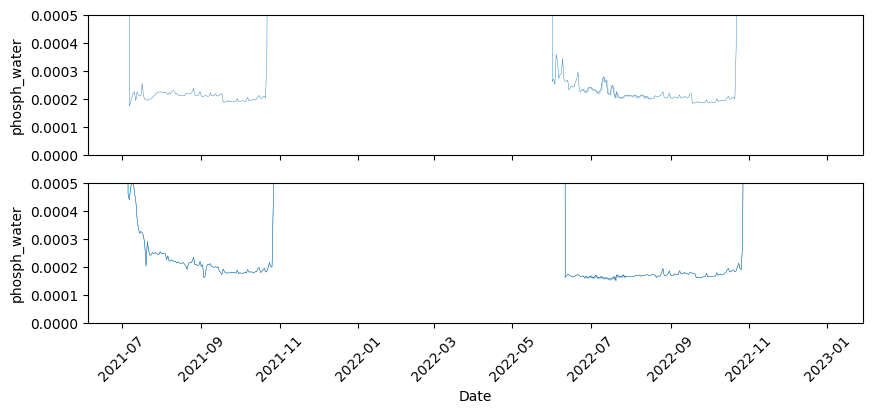

In [57]:
fig, axes = plt.subplots(2,1, figsize=(10,4), sharex=True)

sns.lineplot(data= burned_vars_df[(burned_vars_df['phosph_water']!=-999 ) & (burned_vars_df['depth']==-1.0) & burned_vars_df['run_name'].isin(co2_top_10['run_name'])], x='Date', y='phosph_water', hue = 'run_name', legend=False, linewidth=0.3, ax=axes[0])
plt.xticks(rotation=45)


sns.lineplot(data= unburned_vars_df[(unburned_vars_df['phosph_water']!=-999 ) & (unburned_vars_df['depth']==-1.0) & unburned_vars_df['run_name'].isin(co2_top_10_ub['run_name'])], x='Date', y='phosph_water', hue = 'run_name', legend=False, linewidth=0.3, ax=axes[1])
sns.lineplot(data= unburned_vars_df[(unburned_vars_df['phosph_water']!=-999 ) & (unburned_vars_df['depth']==-1.0) & unburned_vars_df['run_name'].isin(co2_top_10['run_name'])], x='Date', y='phosph_water', hue = 'run_name', legend=False, linewidth=0.3, ax=axes[1])
plt.xticks(rotation=45)

#mg/l phosph
axes[0].set_ylim(0,0.0005)
axes[1].set_ylim(0,0.0005)

In [58]:
burned_methane_df = burned_methane_df.loc[(burned_methane_df['Date']>=time_min) &(burned_methane_df['Date']<=time_max)]
unburned_methane_df = unburned_methane_df.loc[(unburned_methane_df['Date']>=time_min) &(unburned_methane_df['Date']<=time_max)]

<Axes: xlabel='Date', ylabel='methane_ebul_mg/(m**2*day)'>

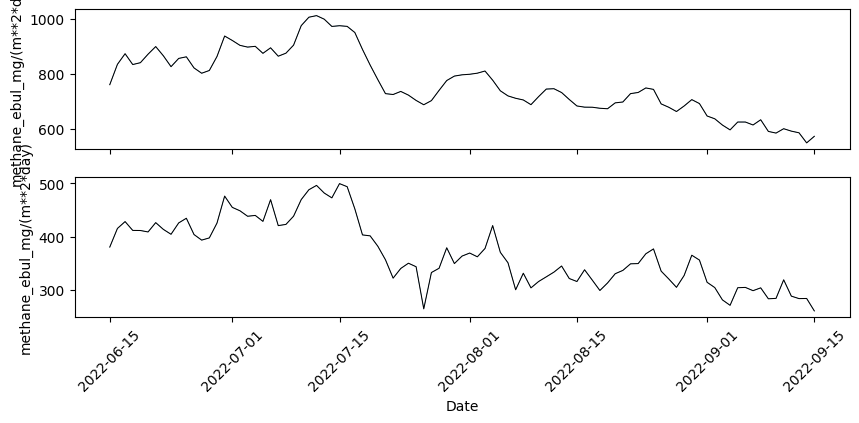

In [59]:
fig, axes = plt.subplots(2,1, figsize=(10,4), sharex=True)

sns.lineplot(data= burned_methane_df[burned_methane_df['run_name'].isin(co2_top_10['run_name'])], x='Date', y='methane_ebul_mg/(m**2*day)', hue = 'run_name', legend=False, linewidth=0.3, ax=axes[0])
sns.lineplot(data= burned_methane_df[burned_methane_df['run_name'].isin(co2_top['run_name'])], x='Date', y='methane_ebul_mg/(m**2*day)',color='black', size=2, legend=False, linewidth=0.3, ax=axes[0])

sns.lineplot(data= unburned_methane_df[unburned_methane_df['run_name'].isin(co2_top_10_ub['run_name'])], x='Date', y='methane_ebul_mg/(m**2*day)', hue = 'run_name', legend=False, linewidth=0.3, ax=axes[1])
plt.xticks(rotation=45)
sns.lineplot(data= unburned_methane_df[unburned_methane_df['run_name'].isin(co2_top['run_name'])], x='Date', y='methane_ebul_mg/(m**2*day)',color='black', size=2, legend=False, linewidth=0.3, ax=axes[1])

In [60]:
burned_methane_df.columns

Index(['Date', 'year', 'month', 'day', 'hour',
       'methane_prod_young_mol/(m**2*s)', 'methane_prod_old_mol/(m**2*s)',
       'methane_diffuse_bot_mol/(m**2*s)', 'methane_ebul_mol/(m**2*s)',
       'methane_ebul_mg/(m**2*day)', 'methane_turb_flux_mol/(m**2*s)',
       'methane_turb_flux_mg/(m**2*day)', 'methane_oxid_mg/(m**2*day)',
       'methane_plant_med_flux_mg/(m**2*day)', 'co2_turb_flux_mol/(m**2*s)',
       'co2_ebul_mol/(m**2*s)', 'ox_turb_flux_mol/(m**2*s)',
       'ox_ebul_mol/(m**2*s)', 'methane_ebul_sc1', 'methane_ebul_sc2',
       'methane_ebul_sc3', 'methane_ebul_sc4', 'methane_ebul_sc5', 'run_name'],
      dtype='object')

<Axes: xlabel='Date', ylabel='methane_turb_flux_mg/(m**2*day)'>

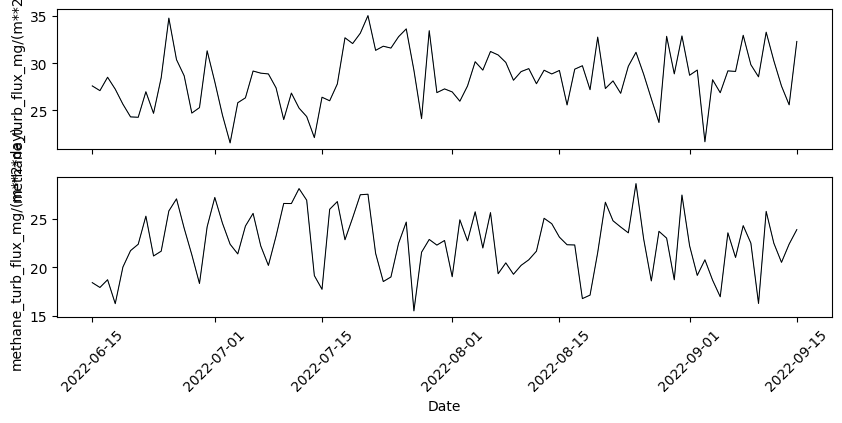

In [61]:
fig, axes = plt.subplots(2,1, figsize=(10,4), sharex=True)

sns.lineplot(data= burned_methane_df[burned_methane_df['run_name'].isin(co2_top_10['run_name'])], x='Date', y='methane_turb_flux_mg/(m**2*day)', hue = 'run_name', legend=False, linewidth=0.3, ax=axes[0])
sns.lineplot(data= burned_methane_df[burned_methane_df['run_name'].isin(co2_top['run_name'])], x='Date', y='methane_turb_flux_mg/(m**2*day)',color='black', size=2, legend=False, linewidth=0.3, ax=axes[0])

sns.lineplot(data= unburned_methane_df[unburned_methane_df['run_name'].isin(co2_top_10_ub['run_name'])], x='Date', y='methane_turb_flux_mg/(m**2*day)', hue = 'run_name', legend=False, linewidth=0.3, ax=axes[1])
plt.xticks(rotation=45)
sns.lineplot(data= unburned_methane_df[unburned_methane_df['run_name'].isin(co2_top['run_name'])], x='Date', y='methane_turb_flux_mg/(m**2*day)',color='black', size=2, legend=False, linewidth=0.3, ax=axes[1])

In [62]:
(1.5e-8)*(1e6)

0.015

<Axes: xlabel='Date', ylabel='methane_prod_young_mol/(m**2*s)'>

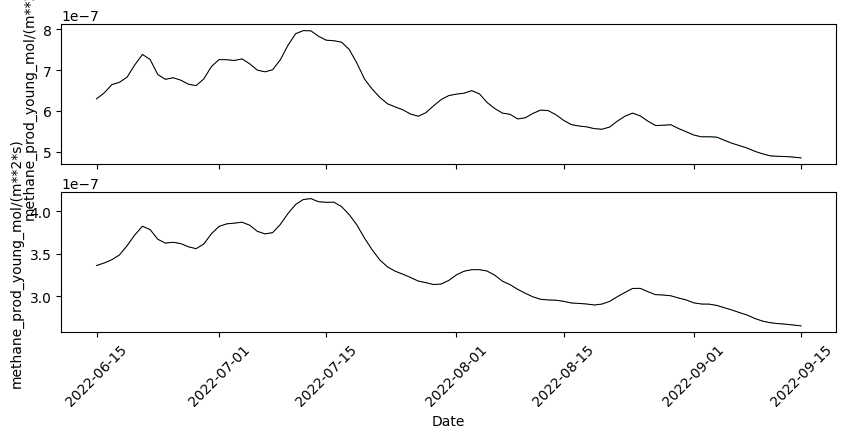

In [63]:
fig, axes = plt.subplots(2,1, figsize=(10,4), sharex=True)

sns.lineplot(data= burned_methane_df[burned_methane_df['run_name'].isin(co2_top_10['run_name'])], x='Date', y='methane_prod_young_mol/(m**2*s)', hue = 'run_name', legend=False, linewidth=0.3, ax=axes[0])
sns.lineplot(data= burned_methane_df[burned_methane_df['run_name'].isin(co2_top['run_name'])], x='Date', y='methane_prod_young_mol/(m**2*s)',color='black', size=2, legend=False, linewidth=0.3, ax=axes[0])

sns.lineplot(data= unburned_methane_df[unburned_methane_df['run_name'].isin(co2_top_10_ub['run_name'])], x='Date', y='methane_prod_young_mol/(m**2*s)', hue = 'run_name', legend=False, linewidth=0.3, ax=axes[1])
plt.xticks(rotation=45)
sns.lineplot(data= unburned_methane_df[unburned_methane_df['run_name'].isin(co2_top['run_name'])], x='Date', y='methane_prod_young_mol/(m**2*s)',color='black', size=2, legend=False, linewidth=0.3, ax=axes[1])

<Axes: xlabel='Date', ylabel='methane_prod_old_mol/(m**2*s)'>

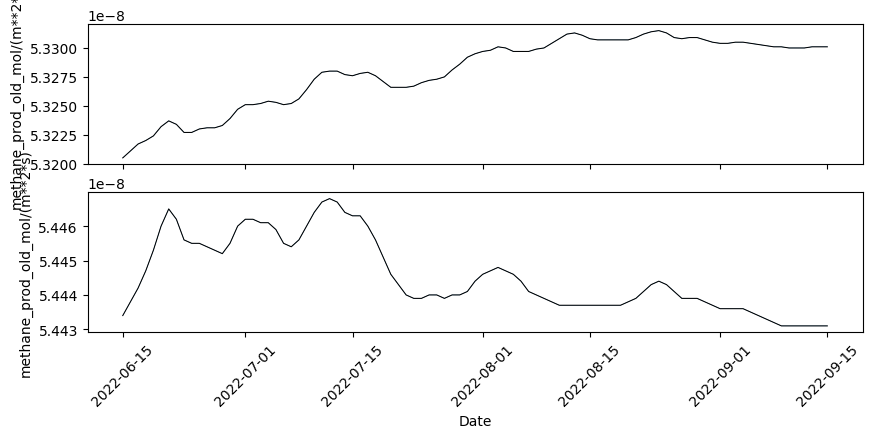

In [64]:
fig, axes = plt.subplots(2,1, figsize=(10,4), sharex=True)

sns.lineplot(data= burned_methane_df[burned_methane_df['run_name'].isin(co2_top_10['run_name'])], x='Date', y='methane_prod_old_mol/(m**2*s)', hue = 'run_name', legend=False, linewidth=0.3, ax=axes[0])
sns.lineplot(data= burned_methane_df[burned_methane_df['run_name'].isin(co2_top['run_name'])], x='Date', y='methane_prod_old_mol/(m**2*s)',color='black', size=2, legend=False, linewidth=0.3, ax=axes[0])

sns.lineplot(data= unburned_methane_df[unburned_methane_df['run_name'].isin(co2_top_10_ub['run_name'])], x='Date', y='methane_prod_old_mol/(m**2*s)', hue = 'run_name', legend=False, linewidth=0.3, ax=axes[1])
plt.xticks(rotation=45)
sns.lineplot(data= unburned_methane_df[unburned_methane_df['run_name'].isin(co2_top['run_name'])], x='Date', y='methane_prod_old_mol/(m**2*s)',color='black', size=2, legend=False, linewidth=0.3, ax=axes[1])

(array([19158., 19174., 19188., 19205., 19219., 19236., 19250.]),
 [Text(19158.0, 0, '2022-06-15'),
  Text(19174.0, 0, '2022-07-01'),
  Text(19188.0, 0, '2022-07-15'),
  Text(19205.0, 0, '2022-08-01'),
  Text(19219.0, 0, '2022-08-15'),
  Text(19236.0, 0, '2022-09-01'),
  Text(19250.0, 0, '2022-09-15')])

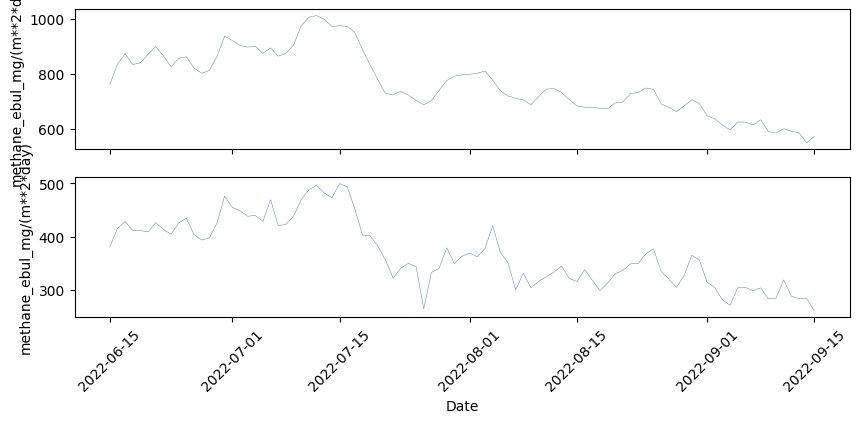

In [65]:
fig, axes = plt.subplots(2,1, figsize=(10,4), sharex=True)

sns.lineplot(data= burned_methane_df[burned_methane_df['run_name'].isin(co2_top_10['run_name'])], x='Date', y='methane_ebul_mg/(m**2*day)', hue = 'run_name', legend=False, linewidth=0.3, ax=axes[0])
sns.lineplot(data= unburned_methane_df[unburned_methane_df['run_name'].isin(co2_top_10_ub['run_name'])], x='Date', y='methane_ebul_mg/(m**2*day)', hue = 'run_name', legend=False, linewidth=0.3, ax=axes[1])
plt.xticks(rotation=45)

In [66]:
co2_top_10_ub['run_name']

0    0
Name: run_name, dtype: int64

<Axes: xlabel='Date', ylabel='pH'>

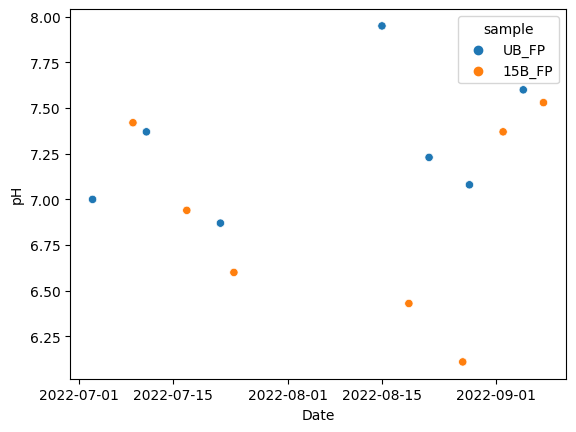

In [67]:
sns.scatterplot(data=ch4_obs, x='Date', y='pH', hue='sample')
#ax.hlines(ch4_obs.loc['ch4_obs'])

In [68]:
burned_vars_df = burned_vars_df.replace(-999, np.nan)
burned_run_summary = burned_vars_df[['run_name', 't_water', 'co2_water', 'ch4_water', 'o2_water', 'prodox', 'doc_water', 'pocl_water', 'phosph_water']].groupby(by='run_name').mean().reset_index()
burned_sensitivity_df = pd.merge(burned_run_summary, burned_sample_matrix, on='run_name')

unburned_vars_df = unburned_vars_df.replace(-999, np.nan)
unburned_run_summary = unburned_vars_df[['run_name', 't_water', 'co2_water', 'ch4_water', 'o2_water', 'prodox', 'doc_water', 'pocl_water', 'phosph_water']].groupby(by='run_name').mean().reset_index()
unburned_sensitivity_df = pd.merge(unburned_run_summary, unburned_sample_matrix, on='run_name')

In [69]:
#co2_top_10['run_name'] = co2_top_10['run_name']
#ch4_top_10['run_name'] = ch4_top_10['run_name']
#o2_top_10['run_name'] = o2_top_10['run_name']

/home/amullen/anaconda3/envs/lake_modeling/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning:

The figure layout has changed to tight



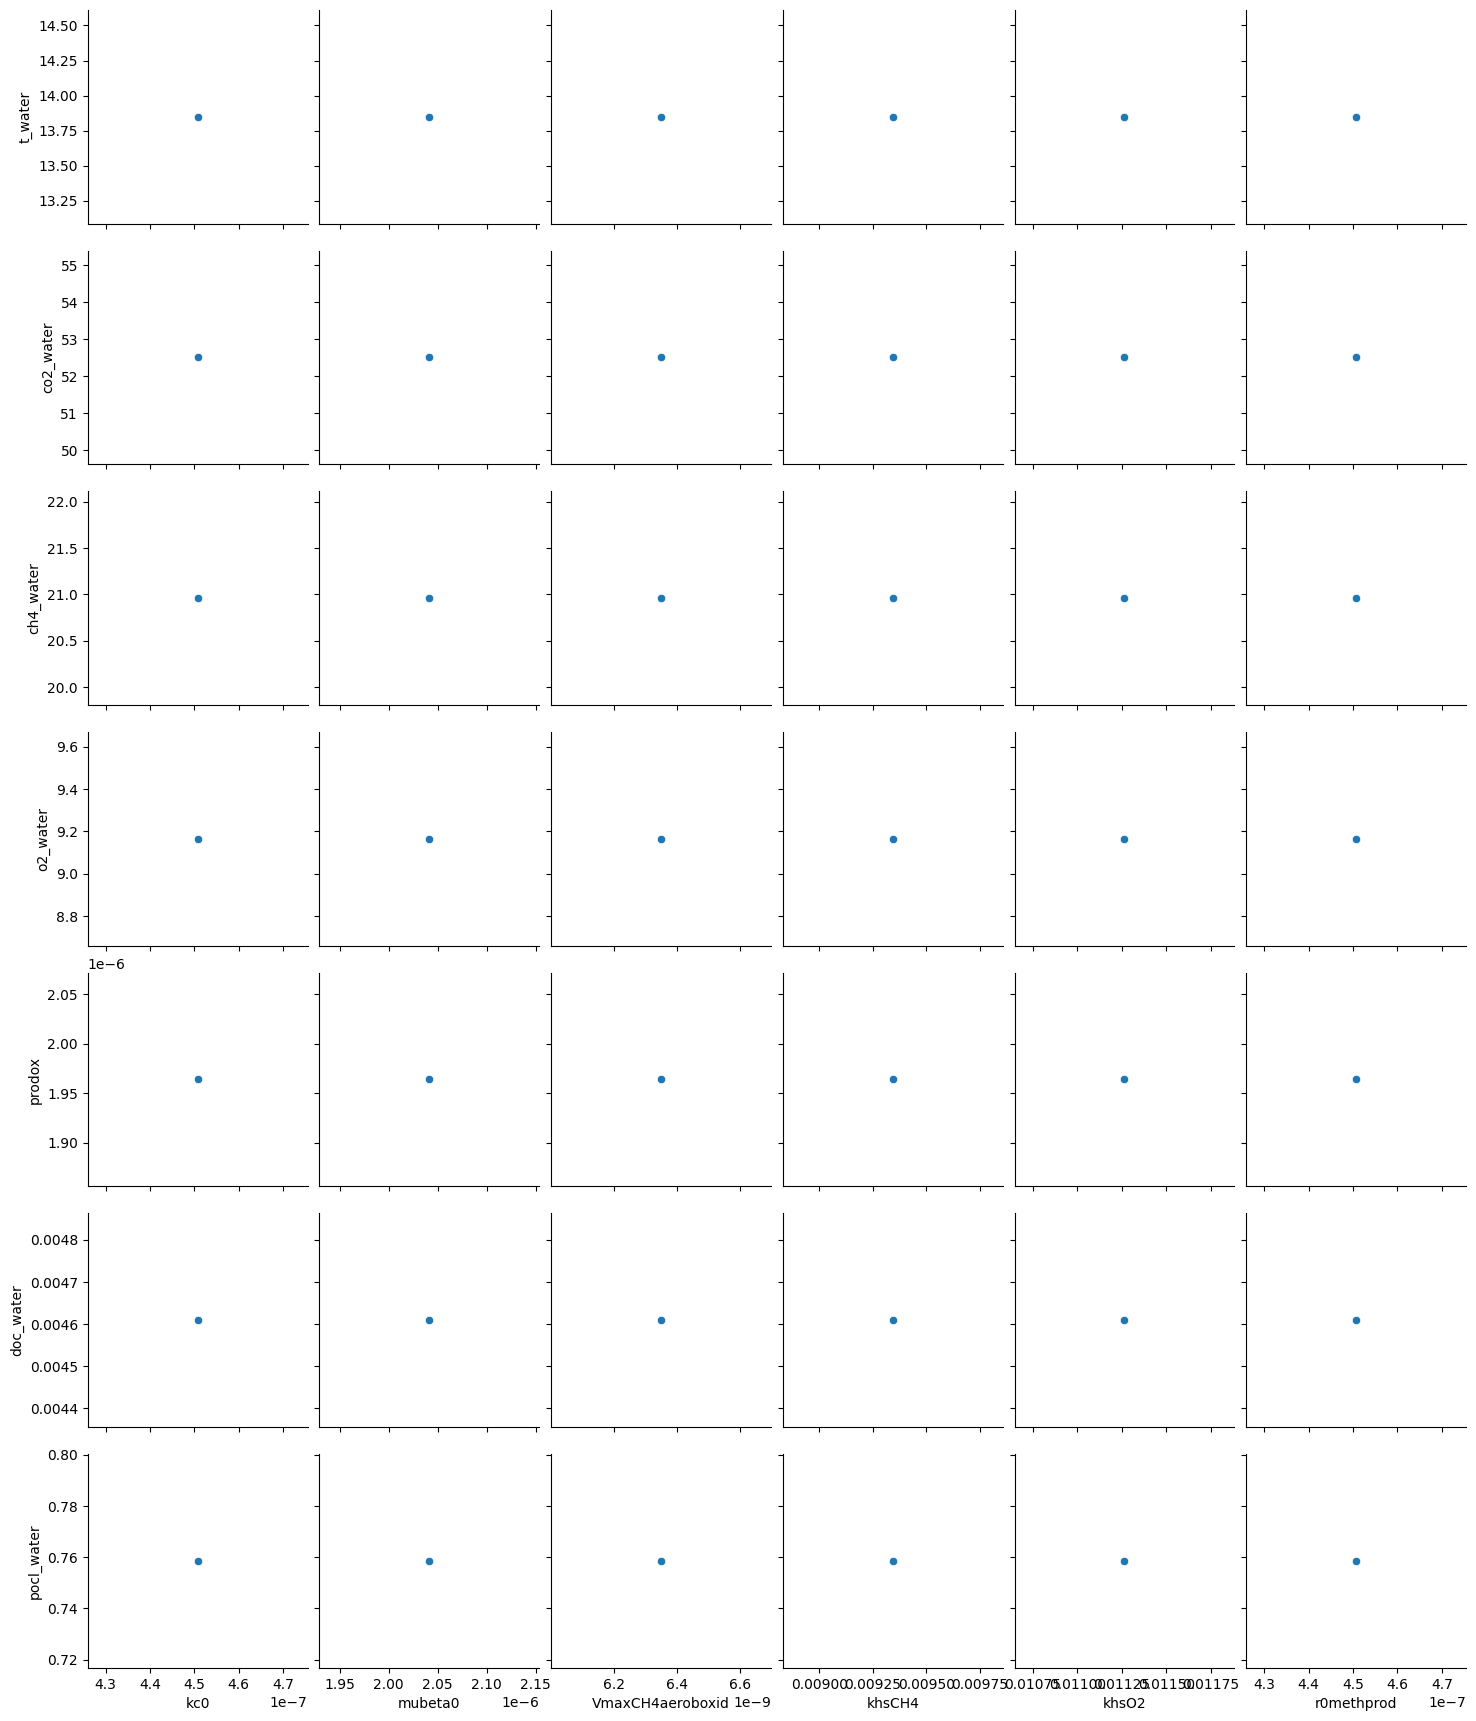

In [70]:
sns.pairplot(burned_sensitivity_df, x_vars=['kc0', 'mubeta0', 'VmaxCH4aeroboxid', 'khsCH4', 'khsO2',
       'r0methprod'], y_vars=['t_water', 'co2_water', 'ch4_water', 'o2_water', 'prodox', 'doc_water', 'pocl_water']) 

/home/amullen/anaconda3/envs/lake_modeling/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning:

The figure layout has changed to tight



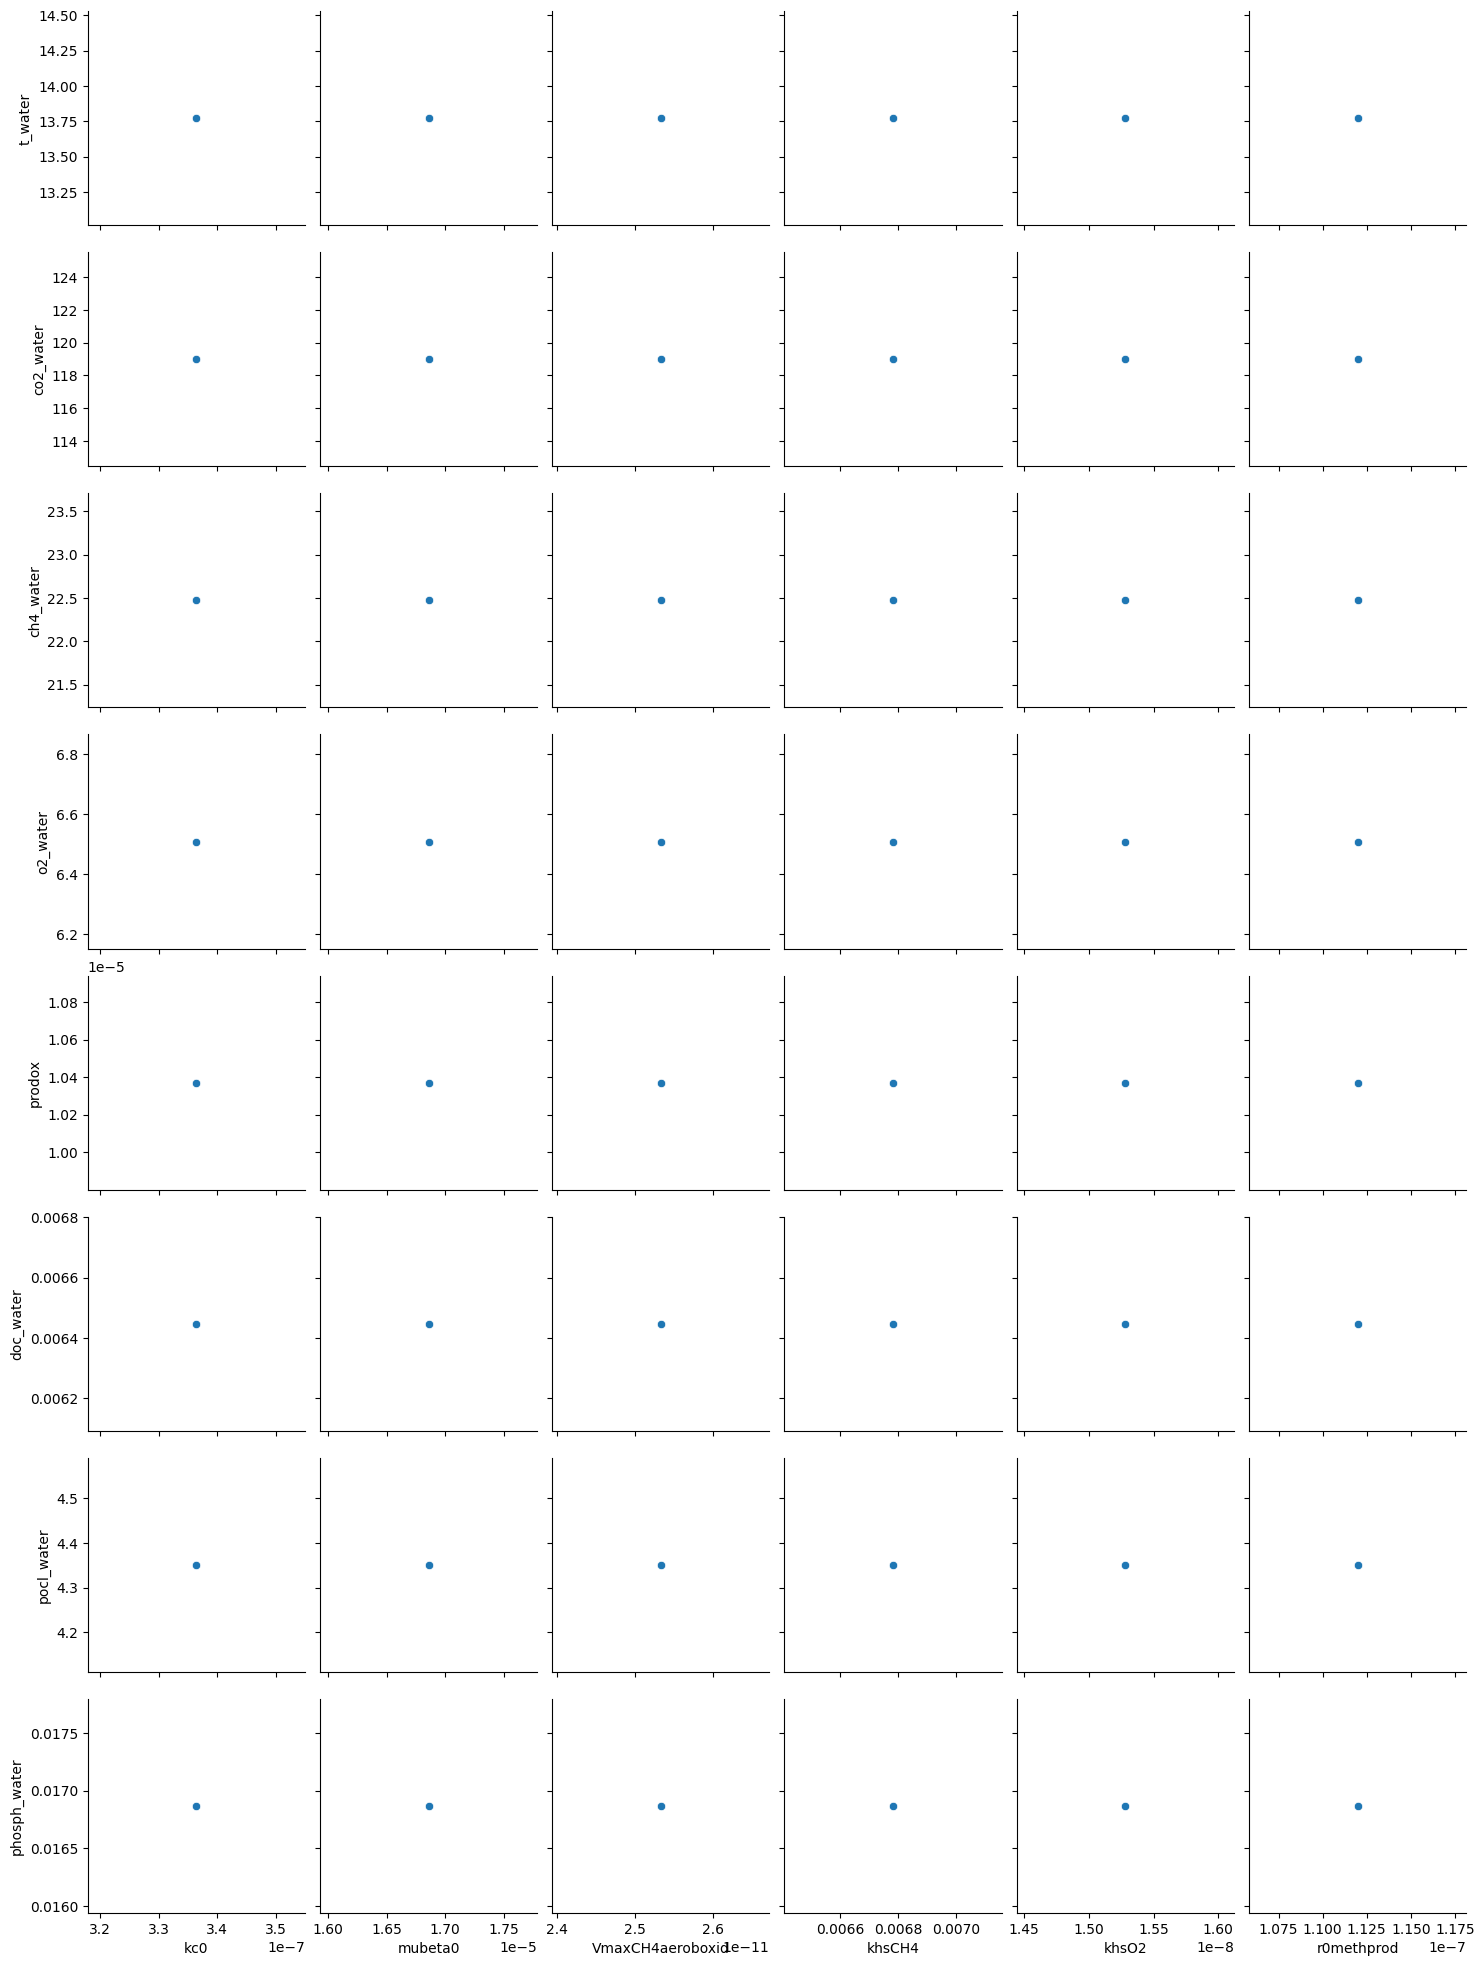

In [71]:
sns.pairplot(unburned_sensitivity_df, x_vars=['kc0', 'mubeta0', 'VmaxCH4aeroboxid', 'khsCH4', 'khsO2', 'r0methprod'], 
             y_vars=['t_water', 'co2_water', 'ch4_water', 'o2_water','prodox', 'doc_water', 'pocl_water', 'phosph_water'])


In [72]:
unburned_sensitivity_df

,run_name,t_water,co2_water,ch4_water,o2_water,prodox,doc_water,pocl_water,phosph_water,kc0,mubeta0,VmaxCH4aeroboxid,khsCH4,khsO2,r0methprod
0,0,13.770651,118.979384,22.470965,6.508691,0.00001,0.006448,4.351274,0.016869,3.364315e-07,0.000017,2.533505e-11,0.006783,1.528162e-08,1.119792e-07


/home/amullen/anaconda3/envs/lake_modeling/lib/python3.11/site-packages/seaborn/matrix.py:202: RuntimeWarning:

All-NaN slice encountered



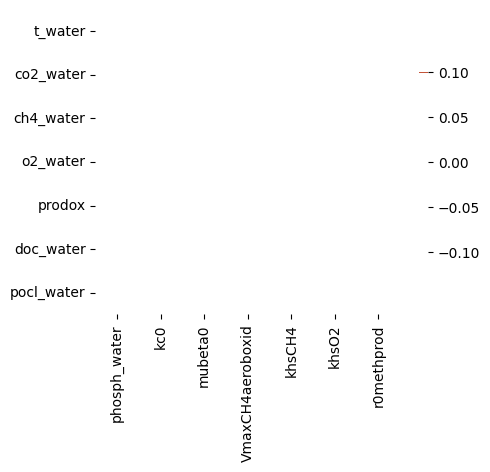

In [73]:
corr=unburned_sensitivity_df.corr()

corr= corr.drop(columns=['run_name', 't_water', 'co2_water', 'ch4_water', 'o2_water', 'prodox', 'doc_water', 'pocl_water'])
corr = corr.loc[['t_water', 'co2_water', 'ch4_water', 'o2_water', 'prodox', 'doc_water', 'pocl_water']]

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

fig, ax = plt.subplots(figsize=(5,5))
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, cmap=cmap, vmax=.3, center=0,annot=False,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
fig.tight_layout()
plt.savefig('YKD-SA/figures/corr_plot_unburned.jpg', dpi=300)

In [74]:
burned_sensitivity_df.loc[burned_sensitivity_df['run_name'].isin(co2_top['run_name'])]

,run_name,t_water,co2_water,ch4_water,o2_water,prodox,doc_water,pocl_water,phosph_water,kc0,mubeta0,VmaxCH4aeroboxid,khsCH4,khsO2,r0methprod
0,0,13.849314,52.509256,20.958616,9.164895,0.000002,0.004609,0.758556,0.010032,4.507214e-07,0.000002,6.349597e-09,0.009343,0.011265,4.506958e-07


In [75]:
burned_sensitivity_df.loc[burned_sensitivity_df['run_name'].isin(ch4_top['run_name'])]

,run_name,t_water,co2_water,ch4_water,o2_water,prodox,doc_water,pocl_water,phosph_water,kc0,mubeta0,VmaxCH4aeroboxid,khsCH4,khsO2,r0methprod
0,0,13.849314,52.509256,20.958616,9.164895,0.000002,0.004609,0.758556,0.010032,4.507214e-07,0.000002,6.349597e-09,0.009343,0.011265,4.506958e-07


In [76]:
burned_sensitivity_df.loc[burned_sensitivity_df['run_name'].isin(o2_top['run_name'])]

,run_name,t_water,co2_water,ch4_water,o2_water,prodox,doc_water,pocl_water,phosph_water,kc0,mubeta0,VmaxCH4aeroboxid,khsCH4,khsO2,r0methprod
0,0,13.849314,52.509256,20.958616,9.164895,0.000002,0.004609,0.758556,0.010032,4.507214e-07,0.000002,6.349597e-09,0.009343,0.011265,4.506958e-07


In [77]:
unburned_sensitivity_df.loc[unburned_sensitivity_df['run_name'].isin(co2_top_ub['run_name'])]

,run_name,t_water,co2_water,ch4_water,o2_water,prodox,doc_water,pocl_water,phosph_water,kc0,mubeta0,VmaxCH4aeroboxid,khsCH4,khsO2,r0methprod
0,0,13.770651,118.979384,22.470965,6.508691,0.00001,0.006448,4.351274,0.016869,3.364315e-07,0.000017,2.533505e-11,0.006783,1.528162e-08,1.119792e-07


In [78]:
unburned_sensitivity_df.loc[unburned_sensitivity_df['run_name'].isin(ch4_top_ub['run_name'])]

,run_name,t_water,co2_water,ch4_water,o2_water,prodox,doc_water,pocl_water,phosph_water,kc0,mubeta0,VmaxCH4aeroboxid,khsCH4,khsO2,r0methprod
0,0,13.770651,118.979384,22.470965,6.508691,0.00001,0.006448,4.351274,0.016869,3.364315e-07,0.000017,2.533505e-11,0.006783,1.528162e-08,1.119792e-07


In [79]:
unburned_sensitivity_df.loc[unburned_sensitivity_df['run_name'].isin(o2_top_ub['run_name'])]

,run_name,t_water,co2_water,ch4_water,o2_water,prodox,doc_water,pocl_water,phosph_water,kc0,mubeta0,VmaxCH4aeroboxid,khsCH4,khsO2,r0methprod
0,0,13.770651,118.979384,22.470965,6.508691,0.00001,0.006448,4.351274,0.016869,3.364315e-07,0.000017,2.533505e-11,0.006783,1.528162e-08,1.119792e-07
